In [516]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from matplotlib.lines import Line2D
import matplotlib.lines as mlines

from mpl_toolkits.mplot3d import Axes3D
import json

import os
import math
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.stats import binned_statistic_2d
from scipy.interpolate import bisplrep,bisplev

from sklearn.neighbors import KernelDensity 
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate
from scipy import interpolate

import xgboost
from xgboost import XGBRegressor, XGBClassifier

from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import seaborn as sns

def create_cyan_to_black_cmap(color1, color2, cmap_name = 'cyan_to_black'):
    colors = [color1, color2]
    return LinearSegmentedColormap.from_list(cmap_name, colors)

# Create the colormap
NP_cmap = create_cyan_to_black_cmap('black', mcolors.to_rgb('darkcyan'), cmap_name = 'NP_cmap')
SM_cmap = create_cyan_to_black_cmap(mcolors.to_rgb('coral'), 'black', cmap_name = 'SM_cmap')

In [3]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import XG, KDE_fitter, max_num_bins
from AUX_MLL_BL import Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve

In [4]:
import matplotlib as mpl
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 

In [5]:
BPs2plot = [2,5,8,11,14]
cmap = cm.get_cmap('Blues', 18)
#cmap = ['coral']
wjets_color = 'coral'
wgamma_color = 'red'
ttgamma_color = 'purple'

# custom functions

In [6]:
def MLL_aprox_discovery_ox(pred_XG_SM, pred_XG_NP, B_expected, S_expected):
   
    pspb_B_data = np.median([im / (1 - im) for im in pred_XG_SM])
    pspb_S_data = np.median([im / (1 - im) for im in pred_XG_NP])
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5



def MLL_aprox_discovery_KDE(pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, S_expected):
   
    pspb_B_data = np.median(pS_B_data/pB_B_data)
    pspb_S_data = np.median(pS_S_data/pB_S_data)
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5


# Reading the data

In [7]:
m      = np.asarray([200, 200, 200, 250, 250, 250, 300, 300, 300, 350, 350, 350, 400, 400, 400])
deltam = np.asarray([34.4, 18.9, 9.9, 36.9, 21.7, 12.5, 39.2, 23.8, 14.7, 41.1, 25.5, 16.7, 42.7, 27.1, 19.3])

Z_base     = np.asarray([0.53, 1.37, 2.29 , 0.32, 0.74, 1.19, 0.21, 0.43, 0.64, 0.13, 0.25, 0.37, 0.07, 0.14, 0.21])

Z_BL0      = np.asarray([2.80, 5.81, 12.84, 1.95, 3.44, 6.67, 1.43, 2.21, 3.73, 0.84, 1.14, 1.86, 0.41, 0.72, 1.08]) # With individual training
Z_BL0_std  = np.asarray([0.76, 0.8 , 0.89 , 0.80, 0.79, 0.83, 0.80, 0.77, 0.70, 0.80, 0.86, 0.83, 0.94, 0.92, 0.87]) # With individual training
Z_BL1      = np.asarray([2.12, 5.49, 11.04, 1.51, 3.46, 6.24, 1.09, 2.21, 3.66, 0.77, 1.43, 2.25, 0.48, 0.91, 1.35]) # Without individual training
Z_BL1_std  = np.asarray([0.75, 0.81, 0.90 , 0.74, 0.77, 0.83, 0.74, 0.74, 0.78, 0.76, 0.74, 0.74, 0.77, 0.72, 0.73]) # Without individual training

Z_MLL0     = np.asarray([3.62, 7.89, 13.82, 2.86, 5.31, 7.62, 2.24, 3.33, 4.89, 1.38, 2.03, 3.08, 0.63, 1.32, 1.55]) # With individual training
Z_MLL0_std = np.asarray([1.23, 1.47, 1.18 , 1.41, 1.49, 1.18, 1.47, 1.22, 1.16, 1.23, 1.20, 1.17, 1.82, 1.34, 1.32]) # With individual training
Z_MLL1     = np.asarray([2.94, 7.31, 12.53, 2.19, 4.94, 7.75, 1.53, 3.37, 5.00, 1.01, 2.23, 3.24, 0.46, 1.33, 1.99]) # Without individual training
Z_MLL1_std = np.asarray([1.17, 1.26, 1.33 , 1.19, 1.22, 1.27, 1.22, 1.23, 1.23, 1.30, 1.20, 1.23, 1.76, 1.23, 1.23]) # Without individual training

Z_SCB0     = np.asarray([2.38, 3.28, 5.87 , 2.01, 3.18, 2.94, 1.39, 1.68, 1.62, 0.55, 0.88, 0.86, 0.54, 0.57, 0.64]) # With individual training
Z_SCB0_std = np.asarray([0.98, 0.90, 0.82 , 0.81, 1.00, 0.74, 0.75, 0.80, 0.67, 0.87, 0.90, 0.87, 0.83, 0.84, 0.84]) # With individual training
Z_SCB1     = np.asarray([0.63, 2.03, 3.99 , 0.42, 1.16, 2.12, 0.27, 0.68, 1.15, 0.19, 0.42, 0.67, 0.13, 0.25, 0.38]) # Without individual training
Z_SCB1_std = np.asarray([0.11, 0.19, 0.27 , 0.09, 0.15, 0.19, 0.07, 0.11, 0.14, 0.05, 0.08, 0.12, 0.03, 0.07, 0.09]) # Without individual training

## SM

In [8]:
ttgamma_cross = 0.13 * 1000 #[fb]
ttgamma_NLO   = 1.46 # k-factor [14 TeV]

Wgamma_cross = 0.944 * 1000 #[fb]
Wgamma_NLO   = 2.37 # k-factor [14 TeV]

Wjets_cross = 168.12 * 1000 #[fb]
Wjets_NLO   = 1.27 # k-factor [14 TeV]

ttjets_cross = 29.0495 * 1000 # [fb]
ttjets_NLO   = 1.47

zjets_cross = 65.85 * 1000 # [fb] solo rama leptonica
zjets_NLO   = 1.35

wz_cross = 0.90 * 1000 # [fb]
wz_NLO   = 1.62

zz_cross = 0.2616 * 1000
zz_NLO   = 1.29

ww_cross = 0.409 * 1000
ww_NLO   = 1.40

tj_cross = 1.598 * 1000
tj_NLO   = 1.03

tb_cross = 2.882 * 1000
tb_NLO   = 1.34

tw_cross = 1.441 * 1000
tw_NLO   = 1.

In [9]:
Wgamma_fidcross  = 110.02191836496351
Wjets_fidcross   = 108.33785910195228
ttgamma_fidcross = 5.23820

ttjets_fidcross  = 22.388
zjets_fidcross   = 3.5025615
wz_fidcross      = 2.2074
zz_fidcross      = 0.2848
ww_fidcross      = 4.197
tj_fidcross      = 0.9348
tb_fidcross      = 1.293
tw_fidcross      = 2.1975

B_fidcross_tot   = Wgamma_fidcross + Wjets_fidcross + ttgamma_fidcross + \
                   ttjets_fidcross + zjets_fidcross + wz_fidcross  + \
                   zz_fidcross + ww_fidcross + tj_fidcross + \
                   tb_fidcross + tw_fidcross 
B_fidcross_tot

260.6030389669158

In [10]:
Wgamma_aceptancia_init  = Wgamma_fidcross / (Wgamma_cross * Wgamma_NLO)
Wjets_aceptancia_init   = Wjets_fidcross / (Wjets_cross * Wjets_NLO)
ttgamma_aceptancia_init = ttgamma_fidcross / (ttgamma_cross * ttgamma_NLO)
ttjets_aceptancia_init  = ttjets_fidcross / (ttjets_cross * ttjets_NLO)
zjets_aceptancia_init   = zjets_fidcross / (zjets_cross * zjets_NLO)
wz_aceptancia_init      = wz_fidcross / (wz_cross * wz_NLO)
zz_aceptancia_init      = zz_fidcross / (zz_cross * zz_NLO)
ww_aceptancia_init      = ww_fidcross / (ww_cross * ww_NLO)
tj_aceptancia_init      = tj_fidcross / (tj_cross * tj_NLO)
tb_aceptancia_init      = tb_fidcross / (tb_cross * tb_NLO)
tw_aceptancia_init      = tw_fidcross / (tw_cross * tw_NLO)

In [11]:
Wgamma_expected  = 11002.191836496351
Wjets_expected   = 10833.785910195227
ttgamma_expected = 523.820

ttjets_expected  = 2238.5992598
zjets_expected   = 350.25615
wz_expected      = 220.74
zz_expected      = 28.481
ww_expected      = 419.71
tj_expected      = 93.489
tb_expected      = 129.372
tw_expected      = 219.75

B_expected = ttgamma_expected + Wjets_expected + Wgamma_expected + ttjets_expected + \
             zjets_expected + wz_expected + zz_expected + ww_expected + \
             tj_expected + tb_expected + tw_expected

print(B_expected)

26060.19515649158


In [12]:
sample = 60_000 # Number of signal and background events to train and validate

Wgamma_sample  = int(round(sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_sample   = int(round(sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_sample = int(round(sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_sample = int(round(sample * ttjets_fidcross / B_fidcross_tot))
zjets_sample = int(round(sample * zjets_fidcross / B_fidcross_tot))
wz_sample = int(round(sample * wz_fidcross / B_fidcross_tot))
zz_sample = int(round(sample * zz_fidcross / B_fidcross_tot))
ww_sample = int(round(sample * ww_fidcross / B_fidcross_tot))
tj_sample = int(round(sample * tj_fidcross / B_fidcross_tot))
tb_sample = int(round(sample * tb_fidcross / B_fidcross_tot))
tw_sample = int(round(sample * tw_fidcross / B_fidcross_tot))

print(Wgamma_sample)
print(Wjets_sample)
print(ttgamma_sample)
print(ttjets_sample)
print(zjets_sample)
print(wz_sample)
print(zz_sample)
print(ww_sample)
print(tj_sample)
print(tb_sample)
print(tw_sample)

25331
24943
1206
5155
806
508
66
966
215
298
506


In [13]:
##############
# input data #
##############

# photon -> (pT, eta, phi, num_photon) from the leading photon
# jet -> (pT, eta, phi) from the leading jet
# lepton -> (pT, eta, phi, num_leptons, num_taus) from the lepton (electron or muon)
# MET -> (pT, eta, phi) eta = 0 by construction, but phi is important because we have a lot of jets that we do not use
# hadinfo -> (HT, HT_had, num_jets)  HT: sum of Pt of all partciles, HT_had: sum PT of all the jets, number of jets (b-tag or not)


######
# SM #
######

# W gamma + W gamma jet #
# Dominant # Np es el W jet el dominant??

datFolderWgamma = '../data/Wgamma/'

photon_Wgamma  = np.loadtxt(datFolderWgamma + 'photon_6.dat', delimiter=' ')
jet_Wgamma     = np.loadtxt(datFolderWgamma + 'jet_6.dat', delimiter=' ')
lepton_Wgamma  = np.loadtxt(datFolderWgamma + 'lepton_6.dat', delimiter=' ')
MET_Wgamma     = np.loadtxt(datFolderWgamma + 'MET_6.dat', delimiter=' ')
hadinfo_Wgamma = np.loadtxt(datFolderWgamma + 'hadinfo_6.dat', delimiter=' ')


# W jet + W jet jet #

datFolderWjets = '../data/Wjets/'

photon_Wjets  = np.loadtxt(datFolderWjets + 'photon_6.dat', delimiter=' ')
jet_Wjets     = np.loadtxt(datFolderWjets + 'jet_6.dat', delimiter=' ')
lepton_Wjets  = np.loadtxt(datFolderWjets + 'lepton_6.dat', delimiter=' ')
MET_Wjets     = np.loadtxt(datFolderWjets + 'MET_6.dat', delimiter=' ')
hadinfo_Wjets = np.loadtxt(datFolderWjets + 'hadinfo_6.dat', delimiter=' ')


# tt gamma + tt gamma jet #

datFolderttgamma = '../data/ttGamma/'
 
photon_ttgamma  = np.loadtxt(datFolderttgamma + 'photon_6.dat', delimiter=' ')
jet_ttgamma     = np.loadtxt(datFolderttgamma + 'jet_6.dat', delimiter=' ')
lepton_ttgamma  = np.loadtxt(datFolderttgamma + 'lepton_6.dat', delimiter=' ')
MET_ttgamma     = np.loadtxt(datFolderttgamma + 'MET_6.dat', delimiter=' ')
hadinfo_ttgamma = np.loadtxt(datFolderttgamma + 'hadinfo_6.dat', delimiter=' ')

# tt  jet #

datFolderttjets = '../data/ttjets/'
 
photon_ttjets  = np.loadtxt(datFolderttjets + 'photon_6.dat', delimiter=' ')
jet_ttjets     = np.loadtxt(datFolderttjets + 'jet_6.dat', delimiter=' ')
lepton_ttjets  = np.loadtxt(datFolderttjets + 'lepton_6.dat', delimiter=' ')
MET_ttjets     = np.loadtxt(datFolderttjets + 'MET_6.dat', delimiter=' ')
hadinfo_ttjets = np.loadtxt(datFolderttjets + 'hadinfo_6.dat', delimiter=' ')

# z jet # rama leptonica

datFolderzjets = '../data/Zlep+j/'
 
photon_zjets  = np.loadtxt(datFolderzjets + 'photon_6.dat', delimiter=' ')
jet_zjets     = np.loadtxt(datFolderzjets + 'jet_6.dat', delimiter=' ')
lepton_zjets  = np.loadtxt(datFolderzjets + 'lepton_6.dat', delimiter=' ')
MET_zjets     = np.loadtxt(datFolderzjets + 'MET_6.dat', delimiter=' ')
hadinfo_zjets = np.loadtxt(datFolderzjets + 'hadinfo_6.dat', delimiter=' ')

# wz #

datFolderwz = '../data/wz/'
 
photon_wz  = np.loadtxt(datFolderwz + 'photon_6.dat', delimiter=' ')
jet_wz     = np.loadtxt(datFolderwz + 'jet_6.dat', delimiter=' ')
lepton_wz  = np.loadtxt(datFolderwz + 'lepton_6.dat', delimiter=' ')
MET_wz     = np.loadtxt(datFolderwz + 'MET_6.dat', delimiter=' ')
hadinfo_wz = np.loadtxt(datFolderwz + 'hadinfo_6.dat', delimiter=' ')

# ww #

datFolderww = '../data/ww/'
 
photon_ww  = np.loadtxt(datFolderww + 'photon_6.dat', delimiter=' ')
jet_ww     = np.loadtxt(datFolderww + 'jet_6.dat', delimiter=' ')
lepton_ww  = np.loadtxt(datFolderww + 'lepton_6.dat', delimiter=' ')
MET_ww     = np.loadtxt(datFolderww + 'MET_6.dat', delimiter=' ')
hadinfo_ww = np.loadtxt(datFolderww + 'hadinfo_6.dat', delimiter=' ')

# zz #

datFolderzz = '../data/zz/'
 
photon_zz  = np.loadtxt(datFolderzz + 'photon_6.dat', delimiter=' ')
jet_zz     = np.loadtxt(datFolderzz + 'jet_6.dat', delimiter=' ')
lepton_zz  = np.loadtxt(datFolderzz + 'lepton_6.dat', delimiter=' ')
MET_zz     = np.loadtxt(datFolderzz + 'MET_6.dat', delimiter=' ')
hadinfo_zz = np.loadtxt(datFolderzz + 'hadinfo_6.dat', delimiter=' ')

# tj #

datFoldertj = '../data/singleTop+j/'
 
photon_tj  = np.loadtxt(datFoldertj + 'photon_6.dat', delimiter=' ')
jet_tj     = np.loadtxt(datFoldertj + 'jet_6.dat', delimiter=' ')
lepton_tj  = np.loadtxt(datFoldertj + 'lepton_6.dat', delimiter=' ')
MET_tj     = np.loadtxt(datFoldertj + 'MET_6.dat', delimiter=' ')
hadinfo_tj = np.loadtxt(datFoldertj + 'hadinfo_6.dat', delimiter=' ')

# tb #

datFoldertb = '../data/singleTop+b/'
 
photon_tb  = np.loadtxt(datFoldertb + 'photon_6.dat', delimiter=' ')
jet_tb     = np.loadtxt(datFoldertb + 'jet_6.dat', delimiter=' ')
lepton_tb  = np.loadtxt(datFoldertb + 'lepton_6.dat', delimiter=' ')
MET_tb     = np.loadtxt(datFoldertb + 'MET_6.dat', delimiter=' ')
hadinfo_tb = np.loadtxt(datFoldertb + 'hadinfo_6.dat', delimiter=' ')

# tw #

datFoldertw = '../data/singleTop+W/'
 
photon_tw  = np.loadtxt(datFoldertw + 'photon_6.dat', delimiter=' ')
jet_tw     = np.loadtxt(datFoldertw + 'jet_6.dat', delimiter=' ')
lepton_tw  = np.loadtxt(datFoldertw + 'lepton_6.dat', delimiter=' ')
MET_tw     = np.loadtxt(datFoldertw + 'MET_6.dat', delimiter=' ')
hadinfo_tw = np.loadtxt(datFoldertw + 'hadinfo_6.dat', delimiter=' ')

In [14]:
photon_SM  = np.concatenate([photon_Wgamma[:Wgamma_sample], photon_Wjets[:Wjets_sample], photon_ttgamma[:ttgamma_sample],
                             photon_ttjets[:ttjets_sample], photon_zjets[:zjets_sample], photon_wz[:wz_sample],
                             photon_zz[:zz_sample], photon_ww[:ww_sample], photon_tj[:tj_sample],
                             photon_tb[:tb_sample], photon_tw[:tw_sample]
                            ])
jet_SM     = np.concatenate([jet_Wgamma[:Wgamma_sample], jet_Wjets[:Wjets_sample], jet_ttgamma[:ttgamma_sample],
                             jet_ttjets[:ttjets_sample], jet_zjets[:zjets_sample], jet_wz[:wz_sample],
                             jet_zz[:zz_sample], jet_ww[:ww_sample], jet_tj[:tj_sample],
                             jet_tb[:tb_sample], jet_tw[:tw_sample]
                            ]) 
lepton_SM  = np.concatenate([lepton_Wgamma[:Wgamma_sample], lepton_Wjets[:Wjets_sample], lepton_ttgamma[:ttgamma_sample],
                             lepton_ttjets[:ttjets_sample], lepton_zjets[:zjets_sample], lepton_wz[:wz_sample],
                             lepton_zz[:zz_sample], lepton_ww[:ww_sample], lepton_tj[:tj_sample],
                             lepton_tb[:tb_sample], lepton_tw[:tw_sample]
                            ])
MET_SM     = np.concatenate([MET_Wgamma[:Wgamma_sample], MET_Wjets[:Wjets_sample], MET_ttgamma[:ttgamma_sample],
                             MET_ttjets[:ttjets_sample], MET_zjets[:zjets_sample], MET_wz[:wz_sample],
                             MET_zz[:zz_sample], MET_ww[:ww_sample], MET_tj[:tj_sample],
                             MET_tb[:tb_sample], MET_tw[:tw_sample]
                            ])
hadinfo_SM = np.concatenate([hadinfo_Wgamma[:Wgamma_sample], hadinfo_Wjets[:Wjets_sample], hadinfo_ttgamma[:ttgamma_sample],
                             hadinfo_ttjets[:ttjets_sample], hadinfo_zjets[:zjets_sample], hadinfo_wz[:wz_sample],
                             hadinfo_zz[:zz_sample], hadinfo_ww[:ww_sample], hadinfo_tj[:tj_sample],
                             hadinfo_tb[:tb_sample], hadinfo_tw[:tw_sample]
                            ])

In [15]:
bkg_flag = np.zeros(len(photon_SM))

bkg_flag[:Wgamma_sample] = 1

init_ind = Wgamma_sample
end_ind  = Wgamma_sample + Wjets_sample
bkg_flag[Wgamma_sample:(Wgamma_sample + Wjets_sample)] = 2

init_ind = end_ind
end_ind  = end_ind + ttgamma_sample
bkg_flag[(init_ind):(end_ind)] = 3

init_ind = end_ind
end_ind  = end_ind + ttjets_sample
bkg_flag[(init_ind):(end_ind)] = 4

init_ind = end_ind
end_ind  = end_ind + zjets_sample
bkg_flag[(init_ind):(end_ind)] = 5

init_ind = end_ind
end_ind  = end_ind + wz_sample
bkg_flag[(init_ind):(end_ind)] = 6

init_ind = end_ind
end_ind  = end_ind + zz_sample
bkg_flag[(init_ind):(end_ind)] = 7

init_ind = end_ind
end_ind  = end_ind + ww_sample
bkg_flag[(init_ind):(end_ind)] = 8

init_ind = end_ind
end_ind  = end_ind + tj_sample
bkg_flag[(init_ind):(end_ind)] = 9

init_ind = end_ind
end_ind  = end_ind + tb_sample
bkg_flag[(init_ind):(end_ind)] = 10

init_ind = end_ind
end_ind  = end_ind + tw_sample
bkg_flag[(init_ind):(end_ind)] = 11

In [16]:
wjets_pool  = len(photon_Wjets[Wjets_sample:])
pool_sample = int(wjets_pool * B_fidcross_tot / Wjets_fidcross)

Wgamma_pool_sample  = int(round(pool_sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_pool_sample   = int(round(pool_sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_pool_sample = int(round(pool_sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_pool_sample  = int(round(pool_sample * ttjets_fidcross / B_fidcross_tot))
zjets_pool_sample   = int(round(pool_sample * zjets_fidcross / B_fidcross_tot))
wz_pool_sample      = int(round(pool_sample * wz_fidcross / B_fidcross_tot))
zz_pool_sample      = int(round(pool_sample * zz_fidcross / B_fidcross_tot))
ww_pool_sample      = int(round(pool_sample * ww_fidcross / B_fidcross_tot))
tj_pool_sample      = int(round(pool_sample * tj_fidcross / B_fidcross_tot))
tb_pool_sample      = int(round(pool_sample * tb_fidcross / B_fidcross_tot))
tw_pool_sample      = int(round(pool_sample * tw_fidcross / B_fidcross_tot))

print(Wgamma_pool_sample)
print(Wjets_pool_sample)
print(ttgamma_pool_sample)
print(ttjets_pool_sample)
print(zjets_pool_sample)
print(wz_pool_sample)
print(zz_pool_sample)
print(ww_pool_sample)
print(tj_pool_sample)
print(tb_pool_sample)
print(tw_pool_sample)

22179
21840
1056
4513
706
445
57
846
188
261
443


In [17]:
len(photon_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)])

4513

In [18]:
photon_SM_pool  = np.concatenate([photon_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  photon_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  photon_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  photon_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  photon_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  photon_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  photon_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  photon_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  photon_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  photon_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  photon_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])

jet_SM_pool     = np.concatenate([jet_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  jet_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  jet_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  jet_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  jet_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  jet_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  jet_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  jet_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  jet_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  jet_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  jet_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ]) 

lepton_SM_pool  = np.concatenate([lepton_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  lepton_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  lepton_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  lepton_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  lepton_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  lepton_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  lepton_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  lepton_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  lepton_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  lepton_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  lepton_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])

MET_SM_pool     = np.concatenate([MET_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  MET_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  MET_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  MET_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  MET_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  MET_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  MET_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  MET_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  MET_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  MET_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  MET_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])

hadinfo_SM_pool = np.concatenate([hadinfo_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  hadinfo_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  hadinfo_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  hadinfo_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  hadinfo_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  hadinfo_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  hadinfo_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  hadinfo_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  hadinfo_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  hadinfo_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  hadinfo_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])


In [19]:
len(photon_SM_pool)

52534

In [20]:
Wgamma_pool_sample+Wjets_pool_sample+ttgamma_pool_sample+ttjets_pool_sample+zjets_pool_sample+wz_pool_sample+zz_pool_sample+ww_pool_sample+tj_pool_sample+ tb_pool_sample+tw_pool_sample 

52534

In [21]:
bkg_flag_pool = np.zeros(len(photon_SM_pool))

bkg_flag_pool[:Wgamma_pool_sample] = 1

init_ind = Wgamma_pool_sample
end_ind  = Wgamma_pool_sample + Wjets_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 2

init_ind = end_ind
end_ind  = end_ind + ttgamma_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 3

init_ind = end_ind
end_ind  = end_ind + ttjets_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 4

init_ind = end_ind
end_ind  = end_ind + zjets_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 5

init_ind = end_ind
end_ind  = end_ind + wz_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 6

init_ind = end_ind
end_ind  = end_ind + zz_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 7

init_ind = end_ind
end_ind  = end_ind + ww_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 8

init_ind = end_ind
end_ind  = end_ind + tj_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 9

init_ind = end_ind
end_ind  = end_ind + tb_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 10

init_ind = end_ind
end_ind  = end_ind + tw_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 11

In [22]:
tw_pool_sample

443

In [23]:
len(np.where(bkg_flag_pool == 11)[0])

443

In [24]:
print(photon_Wjets.shape)
print(photon_ttgamma.shape)
print(photon_Wgamma.shape)
print(photon_ttjets.shape)
print(photon_zjets.shape)
print(photon_wz.shape)
print(photon_zz.shape)
print(photon_ww.shape)
print(photon_tj.shape)
print(photon_tb.shape)
print(photon_tw.shape)

(46783, 4)
(568366, 4)
(673720, 4)
(11533, 4)
(1576, 4)
(3028, 4)
(844, 4)
(7330, 4)
(568, 4)
(670, 4)
(3050, 4)


### other variables, individual channels:

In [25]:
ST_Wgamma = photon_Wgamma[:,0] + lepton_Wgamma[:,0] + jet_Wgamma[:,0]

MET_sig_Wgamma = np.divide( MET_Wgamma[:,0], np.sqrt(hadinfo_Wgamma[:,0]) )

m_eff_Wgamma = MET_Wgamma[:,0] + photon_Wgamma[:,0] + lepton_Wgamma[:,0] + jet_Wgamma[:,0]

phi_MET_photon_Wgamma = np.absolute( MET_Wgamma[:,2] - photon_Wgamma[:,2] )
phi_MET_jet_Wgamma    = np.absolute( MET_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_MET_lepton_Wgamma = np.absolute( MET_Wgamma[:,2] - lepton_Wgamma[:,2] )

mT_photon_Wgamma = np.sqrt( (2*photon_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_photon_Wgamma)) )
mT_jet_Wgamma    = np.sqrt( (2*jet_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_jet_Wgamma)) )
mT_lepton_Wgamma = np.sqrt( (2*lepton_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_lepton_Wgamma)) )

phi_photon_jet_Wgamma    = np.absolute( photon_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_photon_lepton_Wgamma = np.absolute( photon_Wgamma[:,2] - lepton_Wgamma[:,2] )
phi_lepton_jet_Wgamma    = np.absolute( lepton_Wgamma[:,2] - jet_Wgamma[:,2] )

phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]       = (2.* np.pi) - phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]
phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi]
phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]       = (2.* np.pi) - phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]

deltaR_photon_jet_Wgamma    = np.sqrt( (photon_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_photon_jet_Wgamma)**2 )
deltaR_photon_lepton_Wgamma = np.sqrt( (photon_Wgamma[:,1]-lepton_Wgamma[:,1])**2 + (phi_photon_lepton_Wgamma)**2 )
deltaR_lepton_jet_Wgamma    = np.sqrt( (lepton_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_lepton_jet_Wgamma)**2 )

In [26]:
ST_Wjets = photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

MET_sig_Wjets = np.divide( MET_Wjets[:,0],np.sqrt(hadinfo_Wjets[:,0]) )

m_eff_Wjets = MET_Wjets[:,0] + photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

phi_MET_photon_Wjets = np.absolute( MET_Wjets[:,2] - photon_Wjets[:,2] )
phi_MET_jet_Wjets    = np.absolute( MET_Wjets[:,2] - jet_Wjets[:,2] )
phi_MET_lepton_Wjets = np.absolute( MET_Wjets[:,2] - lepton_Wjets[:,2] )

mT_photon_Wjets = np.sqrt( (2*photon_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_photon_Wjets)) )
mT_jet_Wjets    = np.sqrt( (2*jet_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_jet_Wjets)) )
mT_lepton_Wjets = np.sqrt( (2*lepton_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_lepton_Wjets)) )

phi_photon_jet_Wjets    = np.absolute( photon_Wjets[:,2] - jet_Wjets[:,2] )
phi_photon_lepton_Wjets = np.absolute( photon_Wjets[:,2] - lepton_Wjets[:,2] )
phi_lepton_jet_Wjets    = np.absolute( lepton_Wjets[:,2] - jet_Wjets[:,2] )

phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]       = (2.* np.pi) - phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]
phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi] = (2.* np.pi) - phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi]
phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]       = (2.* np.pi) - phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]

deltaR_photon_jet_Wjets    = np.sqrt( (photon_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_photon_jet_Wjets)**2 )
deltaR_photon_lepton_Wjets = np.sqrt( (photon_Wjets[:,1]-lepton_Wjets[:,1])**2 + (phi_photon_lepton_Wjets)**2 )
deltaR_lepton_jet_Wjets    = np.sqrt( (lepton_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_lepton_jet_Wjets)**2 )

In [27]:
ST_ttgamma = photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

MET_sig_ttgamma = np.divide( MET_ttgamma[:,0],np.sqrt(hadinfo_ttgamma[:,0]) )

m_eff_ttgamma = MET_ttgamma[:,0] + photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

phi_MET_photon_ttgamma = np.absolute( MET_ttgamma[:,2] - photon_ttgamma[:,2] )
phi_MET_jet_ttgamma    = np.absolute( MET_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_MET_lepton_ttgamma = np.absolute( MET_ttgamma[:,2] - lepton_ttgamma[:,2] )

mT_photon_ttgamma = np.sqrt( (2*photon_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_photon_ttgamma)) )
mT_jet_ttgamma    = np.sqrt( (2*jet_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_jet_ttgamma)) )
mT_lepton_ttgamma = np.sqrt( (2*lepton_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_lepton_ttgamma)) )

phi_photon_jet_ttgamma    = np.absolute( photon_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_photon_lepton_ttgamma = np.absolute( photon_ttgamma[:,2] - lepton_ttgamma[:,2] )
phi_lepton_jet_ttgamma    = np.absolute( lepton_ttgamma[:,2] - jet_ttgamma[:,2] )

phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]       = (2.* np.pi) - phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]
phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi]
phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]       = (2.* np.pi) - phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]

deltaR_photon_jet_ttgamma    = np.sqrt( (photon_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_photon_jet_ttgamma)**2 )
deltaR_photon_lepton_ttgamma = np.sqrt( (photon_ttgamma[:,1]-lepton_ttgamma[:,1])**2 + (phi_photon_lepton_ttgamma)**2 )
deltaR_lepton_jet_ttgamma    = np.sqrt( (lepton_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_lepton_jet_ttgamma)**2 )

In [28]:
# other variables

ST_SM = photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

MET_sig_SM = np.divide( MET_SM[:,0],np.sqrt(hadinfo_SM[:,0]) )

m_eff_SM = MET_SM[:,0] + photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

phi_MET_photon_SM = np.absolute( MET_SM[:,2] - photon_SM[:,2] )
phi_MET_jet_SM    = np.absolute( MET_SM[:,2] - jet_SM[:,2] )
phi_MET_lepton_SM = np.absolute( MET_SM[:,2] - lepton_SM[:,2] )

mT_photon_SM = np.sqrt( (2*photon_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_photon_SM)) )
mT_jet_SM    = np.sqrt( (2*jet_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_jet_SM)) )
mT_lepton_SM = np.sqrt( (2*lepton_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_lepton_SM)) )

phi_photon_jet_SM    = np.absolute( photon_SM[:,2] - jet_SM[:,2] )
phi_photon_lepton_SM = np.absolute( photon_SM[:,2] - lepton_SM[:,2] )
phi_lepton_jet_SM    = np.absolute( lepton_SM[:,2] - jet_SM[:,2] )

phi_photon_jet_SM[phi_photon_jet_SM>np.pi]       = (2.* np.pi) - phi_photon_jet_SM[phi_photon_jet_SM>np.pi]
phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi] = (2.* np.pi) - phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi]
phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]

deltaR_photon_jet_SM    = np.sqrt( (photon_SM[:,1]-jet_SM[:,1])**2 + (phi_photon_jet_SM)**2 )
deltaR_photon_lepton_SM = np.sqrt( (photon_SM[:,1]-lepton_SM[:,1])**2 + (phi_photon_lepton_SM)**2 )
deltaR_lepton_jet_SM    = np.sqrt( (lepton_SM[:,1]-jet_SM[:,1])**2 + (phi_lepton_jet_SM)**2 )

In [29]:
# other variables, individual channels pool sample:

ST_SM_pool = photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

MET_sig_SM_pool = np.divide( MET_SM_pool[:,0],np.sqrt(hadinfo_SM_pool[:,0]) )

m_eff_SM_pool = MET_SM_pool[:,0] + photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

phi_MET_photon_SM_pool = np.absolute( MET_SM_pool[:,2] - photon_SM_pool[:,2] )
phi_MET_jet_SM_pool    = np.absolute( MET_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_MET_lepton_SM_pool = np.absolute( MET_SM_pool[:,2] - lepton_SM_pool[:,2] )

mT_photon_SM_pool = np.sqrt( (2*photon_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_photon_SM_pool)) )
mT_jet_SM_pool    = np.sqrt( (2*jet_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_jet_SM_pool)) )
mT_lepton_SM_pool = np.sqrt( (2*lepton_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_lepton_SM_pool)) )

phi_photon_jet_SM_pool    = np.absolute( photon_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_photon_lepton_SM_pool = np.absolute( photon_SM_pool[:,2] - lepton_SM_pool[:,2] )
phi_lepton_jet_SM_pool    = np.absolute( lepton_SM_pool[:,2] - jet_SM_pool[:,2] )

phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]
phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi] = (2.* np.pi) - phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi]
phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]

deltaR_photon_jet_SM_pool    = np.sqrt( (photon_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_photon_jet_SM_pool)**2 )
deltaR_photon_lepton_SM_pool = np.sqrt( (photon_SM_pool[:,1]-lepton_SM_pool[:,1])**2 + (phi_photon_lepton_SM_pool)**2 )
deltaR_lepton_jet_SM_pool    = np.sqrt( (lepton_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_lepton_jet_SM_pool)**2 )

## NP

In [30]:
######
# NP #
######

datFolderNP = '../data/Signal/'

photon_NP  = []
jet_NP     = []
lepton_NP  = []
MET_NP     = []
hadinfo_NP = []
name       = []
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    name.append('BP' + str(i))
    photon_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_photon_6.dat', delimiter=' ') )
    jet_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_jet_6.dat', delimiter=' ') )
    lepton_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_lepton_6.dat', delimiter=' ') )
    MET_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_MET_6.dat', delimiter=' ') )
    hadinfo_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_hadinfo_6.dat', delimiter=' ') )

In [31]:
print('SM', lepton_SM.shape)
for i in range(len(jet_NP)):
    print(name[i], lepton_NP[i].shape)

SM (60000, 5)
BP1 (210768, 5)
BP2 (220621, 5)
BP3 (224270, 5)
BP4 (268160, 5)
BP5 (254511, 5)
BP6 (218307, 5)
BP7 (302978, 5)
BP8 (279921, 5)
BP9 (244546, 5)
BP10 (330992, 5)
BP11 (302374, 5)
BP12 (268335, 5)
BP13 (356324, 5)
BP14 (324324, 5)
BP15 (288862, 5)


In [32]:
cross_section_bps    = np.asarray([190, 189, 189, 92, 92, 92, 49, 48, 48, 27, 27, 27, 16, 16, 16])
branching_ratios_bps = np.asarray([0.14, 0.37, 0.73, 0.15, 0.36, 0.67, 0.16, 0.36, 0.62, 0.17, 0.35, 0.58, 0.16, 0.32, 0.52])

signal_cross        = cross_section_bps * branching_ratios_bps *  0.2134 # fb
signal_init_sim_eve = np.asarray([1836673, 2e6, 2400081, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6])
#signal_cut_ev       = np.asarray([238160,246196,242249,301575,266047,203155,315960,280065,225958,326687,292051,244271,334782,301215,258277]) #OLD
signal_cut_ev       = np.asarray([210768, 220621, 224270, 268160, 254511, 218307, 302978, 279921, 244546, 330992, 302374, 268335, 356324, 324324, 288862])
signal_NLO          = 1.25

cross       = signal_cross * signal_NLO
aceptancia  = signal_cut_ev / (1. * signal_init_sim_eve)
luminosidad = 100

signal_fidcross = cross * aceptancia
S_expected = cross * aceptancia * luminosidad

print('fiducial cross section: ', signal_fidcross)
print('Events expected: ', S_expected)

fiducial cross section:  [0.81425212 2.05771304 3.43901743 0.49356859 1.1242718  1.79475315
 0.31681198 0.64513953 0.97066177 0.20263041 0.3811103  0.56045857
 0.12166327 0.22147437 0.32054438]
Events expected:  [ 81.42521191 205.77130384 343.90174266  49.3568592  112.42718012
 179.47531491  31.68119755  64.51395271  97.0661765   20.26304062
  38.11102998  56.04585686  12.16632666  22.14743731  32.05443842]


In [33]:
# other variables NEW PHYSICS
ST_NP      = []
MET_sig_NP = []
m_eff_NP   = []

phi_MET_photon_NP = []
phi_MET_jet_NP    = []
phi_MET_lepton_NP = []

mT_photon_NP = []
mT_jet_NP    = []
mT_lepton_NP = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

deltaR_photon_jet_NP    = []
deltaR_photon_lepton_NP = []
deltaR_lepton_jet_NP    = []

for i in range(len(photon_NP)):
    ST_NP.append( photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    MET_sig_NP.append( np.divide( MET_NP[i][:,0],np.sqrt(hadinfo_NP[i][:,0]) ) )

    m_eff_NP.append( MET_NP[i][:,0] + photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    phi_MET_photon_NP.append( np.absolute( MET_NP[i][:,2] - photon_NP[i][:,2] ) )
    phi_MET_jet_NP.append( np.absolute( MET_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_MET_lepton_NP.append( np.absolute( MET_NP[i][:,2] - lepton_NP[i][:,2] ) )

    mT_photon_NP.append( np.sqrt( (2*photon_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_photon_NP[i])) ) )
    mT_jet_NP.append( np.sqrt( (2*jet_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_jet_NP[i])) ) )
    mT_lepton_NP.append( np.sqrt( (2*lepton_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_lepton_NP[i])) ) )

    phi_photon_jet_NP.append( np.absolute( photon_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_photon_lepton_NP.append( np.absolute( photon_NP[i][:,2] - lepton_NP[i][:,2] ) )
    phi_lepton_jet_NP.append( np.absolute( lepton_NP[i][:,2] - jet_NP[i][:,2] ) )

    phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]
    phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi] = (2.* np.pi) - phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi]
    phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]

    deltaR_photon_jet_NP.append( np.sqrt( (photon_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_photon_jet_NP[i])**2 ) )
    deltaR_photon_lepton_NP.append( np.sqrt( (photon_NP[i][:,1]-lepton_NP[i][:,1])**2 + (phi_photon_lepton_NP[i])**2 ) )
    deltaR_lepton_jet_NP.append( np.sqrt( (lepton_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_lepton_jet_NP[i])**2 ) )

In [34]:
print(photon_SM.shape)
print(photon_SM_pool.shape)
print(photon_NP[0].shape)

(60000, 4)
(52534, 4)
(210768, 4)


# Analysis

## training

In [35]:
Z_MLL_loops = [np.array([ 1.86306558,  6.31102988, 12.03605784,  1.23858369,  4.09875261,
                          8.06491533,  0.70129333,  2.86901809,  4.99620008,  0.34949172,
                          1.86201525,  3.50808937,  0.09933664,  1.00656169,  2.07621459])]
Z_MLL_std_loops = [np.array([2.46956084, 1.3687612 , 1.24029677, 1.22455103, 1.32363129,
                             1.42391585, 1.48259007, 1.32903133, 1.42424584, 5.64019541,
                             1.17520048, 1.32301935, 7.55757447, 1.26034699, 1.24417709])]
muhat_MLL_loops = [np.array([0.81235 , 1.1578  , 1.536   , 0.9252  , 1.3001  , 1.6103  ,
                             0.873125, 1.37795 , 1.610025, 0.88325 , 1.363375, 1.640975,
                             0.84325 , 1.18325 , 1.495775])]

Z_BL_loops = [np.array([ 1.54510007,  4.6617903 , 10.04804473,  1.08554459,  2.84585512,
                         5.50405332,  0.74473692,  1.78090032,  3.15462591,  0.53484744,
                         1.18533744,  1.89027926,  0.34060097,  0.68952131,  1.1135407 ])]
Z_BL_std_loops = [np.array([0.81326303, 0.83071974, 0.89776161, 0.82682351, 0.80350111,
                            0.81276647, 0.86245773, 0.81704573, 0.79499652, 0.89064987,
                            0.78376941, 0.78604751, 0.87143215, 0.87312314, 0.8283627 ])]
muhat_BL_loops = [np.array([1.025575, 1.024875, 1.026575, 1.01195 , 1.020375, 1.0224  ,
                            0.9779  , 1.011475, 1.0254  , 1.0047  , 1.0231  , 1.006125,
                            0.992325, 0.9891  , 0.982725])]

In [472]:
lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

In [473]:
nobs = len(photon_SM)
#BPS_trained = np.asarray([0]) #np.arange(15)
BPS_trained = np.arange(15)
nobs_bp = round(nobs / len(BPS_trained))

SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

df = pd.DataFrame()

#np.random.seed(28890)

mask_list = []
for bp in BPS_trained:
    print(bp)
    BP_indices = np.random.choice(np.arange(len(photon_NP[bp])), size = nobs_bp, replace = False)
    mask = np.ones(len(photon_NP[bp]), dtype=bool)
    mask[BP_indices] = False
    mask_list.append( mask )
    
    if bp == 0:
        
        df[lst[0]] = np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][BP_indices,0]])
        df[lst[1]] = np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][BP_indices,1]])
        df[lst[2]] = np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][BP_indices,2]])
        df[lst[3]] = np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][BP_indices,3]])

        df[lst[4]] = np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][BP_indices,0]])
        df[lst[5]] = np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][BP_indices,1]])
        df[lst[6]] = np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][BP_indices,2]])

        df[lst[7]] = np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][BP_indices,0]])
        df[lst[8]] = np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][BP_indices,1]])
        df[lst[9]] = np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][BP_indices,2]])
        df[lst[10]] = np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][BP_indices,3]])
        df[lst[11]] = np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][BP_indices,4]])

        df[lst[12]] = np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][BP_indices,0]])
        df[lst[13]] = np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][BP_indices,2]])

        df[lst[14]] = np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][BP_indices,0]])
        df[lst[15]] = np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][BP_indices,1]])
        df[lst[16]] = np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][BP_indices,2]])

        df[lst[17]] = np.concatenate([ST_SM[SM_indices], ST_NP[bp][BP_indices]])
        df[lst[18]] = np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][BP_indices]])

        df[lst[19]] = np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][BP_indices]])
        df[lst[20]] = np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][BP_indices]])
        df[lst[21]] = np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][BP_indices]])


        df['bkg_flag'] = np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][BP_indices]))) )

        df[lst[22]] = np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][BP_indices]))])
        
        df['bp_flag'] = np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][BP_indices])) * (bp+1) ])
    else:
        df_aux = pd.DataFrame()
        
        df_aux[lst[0]] = photon_NP[bp][BP_indices,0] 
        df_aux[lst[1]] = photon_NP[bp][BP_indices,1] 
        df_aux[lst[2]] = photon_NP[bp][BP_indices,2] 
        df_aux[lst[3]] = photon_NP[bp][BP_indices,3] 

        df_aux[lst[4]] = jet_NP[bp][BP_indices,0] 
        df_aux[lst[5]] = jet_NP[bp][BP_indices,1] 
        df_aux[lst[6]] = jet_NP[bp][BP_indices,2] 

        df_aux[lst[7]] = lepton_NP[bp][BP_indices,0] 
        df_aux[lst[8]] = lepton_NP[bp][BP_indices,1] 
        df_aux[lst[9]] = lepton_NP[bp][BP_indices,2] 
        df_aux[lst[10]] = lepton_NP[bp][BP_indices,3] 
        df_aux[lst[11]] = lepton_NP[bp][BP_indices,4] 

        df_aux[lst[12]] = MET_NP[bp][BP_indices,0] 
        df_aux[lst[13]] = MET_NP[bp][BP_indices,2] 

        df_aux[lst[14]] = hadinfo_NP[bp][BP_indices,0] 
        df_aux[lst[15]] = hadinfo_NP[bp][BP_indices,1] 
        df_aux[lst[16]] = hadinfo_NP[bp][BP_indices,2] 

        df_aux[lst[17]] = ST_NP[bp][BP_indices] 
        df_aux[lst[18]] = MET_sig_NP[bp][BP_indices] 

        df_aux[lst[19]] = mT_photon_NP[bp][BP_indices] 
        df_aux[lst[20]] = mT_jet_NP[bp][BP_indices] 
        df_aux[lst[21]] = mT_lepton_NP[bp][BP_indices] 


        df_aux['bkg_flag'] = np.zeros(len(photon_NP[bp][BP_indices]))

        df_aux[lst[22]] = np.ones(len(photon_NP[bp][BP_indices]))
        df_aux['bp_flag'] = np.ones(len(photon_NP[bp][BP_indices])) * (bp+1) 
        
        df = pd.concat((df, df_aux))
df_array = np.asarray(df)
df

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag,SM=0 - NP=1,bp_flag
0,13.22,-2.040,0.120,1.0,446.68,-0.546,1.641,94.85,1.058,-1.456,...,550.52,3.0,554.75,11.603082,86.402700,728.464145,9.578008,1.0,0.0,0.0
1,12.97,1.276,0.356,1.0,263.15,-0.370,1.299,44.10,1.620,-2.490,...,263.15,1.0,320.22,13.159768,97.117092,497.700118,69.887617,2.0,0.0,0.0
2,72.04,0.013,-2.473,1.0,450.14,-1.070,0.416,68.12,-1.733,-2.607,...,518.45,3.0,590.30,13.311176,73.206771,779.604516,51.165292,2.0,0.0,0.0
3,132.41,-0.647,1.866,1.0,186.10,-1.466,0.604,91.60,-1.096,-1.472,...,426.17,4.0,410.11,10.326438,372.181729,377.714629,4.969502,2.0,0.0,0.0
4,14.83,-1.004,-0.283,1.0,247.45,-2.405,0.430,194.83,0.436,3.002,...,595.78,5.0,457.11,8.774052,119.567083,488.770528,47.743346,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,42.12,0.725,1.328,1.0,517.28,0.649,-2.195,13.64,-0.272,-0.878,...,862.06,5.0,573.04,20.717568,11.379215,1125.811700,162.150495,0.0,1.0,15.0
3996,25.42,-0.175,1.859,1.0,973.96,1.245,-1.490,29.33,0.496,1.240,...,973.96,1.0,1028.71,29.074461,29.209021,1905.957375,70.405558,0.0,1.0,15.0
3997,13.58,0.876,-2.729,1.0,102.55,-1.432,0.550,23.33,0.796,0.494,...,230.32,3.0,139.46,13.941250,13.319579,305.350305,145.375992,0.0,1.0,15.0
3998,19.65,-0.782,-2.269,1.0,283.17,1.258,-0.991,22.67,0.352,2.021,...,378.76,3.0,325.49,12.615353,131.482979,525.872024,26.826551,0.0,1.0,15.0


In [474]:
print('There are ' + str(len(np.where(df_array[:,24] == 0)[0])) + ' bkg events')
for i in np.arange(15):
    print('There are ' + str(len(np.where(df_array[:,24] == (i+1))[0])) + ' BP' + str(i+1) + ' events')

There are 60000 bkg events
There are 4000 BP1 events
There are 4000 BP2 events
There are 4000 BP3 events
There are 4000 BP4 events
There are 4000 BP5 events
There are 4000 BP6 events
There are 4000 BP7 events
There are 4000 BP8 events
There are 4000 BP9 events
There are 4000 BP10 events
There are 4000 BP11 events
There are 4000 BP12 events
There are 4000 BP13 events
There are 4000 BP14 events
There are 4000 BP15 events


In [475]:
SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

#BPS_analyzed = np.asarray([0])
BPS_analyzed = np.arange(15)

df_test = pd.DataFrame()

for bp in BPS_analyzed:
    if bp in BPS_trained:
        mask = mask_list[np.where(BPS_trained == bp)[0][0]]
        mask[np.random.choice(np.arange(len(mask)), (len(mask) - 100_000), replace = False)] = False # Set to false everything but 75000
    else:
        BP_indices = np.random.choice(np.arange(len(photon_NP[bp])), size = 15_000, replace = False)
        mask = np.zeros(len(photon_NP[bp]), dtype=bool)
        mask[BP_indices] = True
    print(bp)
    #mask = mask_list[bp]
    #mask[np.random.choice(np.arange(len(mask)), (len(mask) - 100_000), replace = False)] = False # Set to false everything but 15000
    if bp == 0:
        
        df_test[lst[0]] = np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][mask,0]])
        df_test[lst[1]] = np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][mask,1]])
        df_test[lst[2]] = np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][mask,2]])
        df_test[lst[3]] = np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][mask,3]])

        df_test[lst[4]] = np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][mask,0]])
        df_test[lst[5]] = np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][mask,1]])
        df_test[lst[6]] = np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][mask,2]])

        df_test[lst[7]] = np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][mask,0]])
        df_test[lst[8]] = np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][mask,1]])
        df_test[lst[9]] = np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][mask,2]])
        df_test[lst[10]] = np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][mask,3]])
        df_test[lst[11]] = np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][mask,4]])

        df_test[lst[12]] = np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][mask,0]])
        df_test[lst[13]] = np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][mask,2]])

        df_test[lst[14]] = np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][mask,0]])
        df_test[lst[15]] = np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][mask,1]])
        df_test[lst[16]] = np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][mask,2]])

        df_test[lst[17]] = np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][mask]])
        df_test[lst[18]] = np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][mask]])

        df_test[lst[19]] = np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][mask]])
        df_test[lst[20]] = np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][mask]])
        df_test[lst[21]] = np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][mask]])


        df_test['bkg_flag_pool'] = np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][mask]))) )

        df_test[lst[22]] = np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][mask]))])
        
        df_test['bp_flag'] = np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][mask])) * (bp+1) ])
        
    else:
        df_aux = pd.DataFrame()
        
        df_aux[lst[0]] = photon_NP[bp][mask,0] 
        df_aux[lst[1]] = photon_NP[bp][mask,1] 
        df_aux[lst[2]] = photon_NP[bp][mask,2] 
        df_aux[lst[3]] = photon_NP[bp][mask,3] 

        df_aux[lst[4]] = jet_NP[bp][mask,0] 
        df_aux[lst[5]] = jet_NP[bp][mask,1] 
        df_aux[lst[6]] = jet_NP[bp][mask,2] 

        df_aux[lst[7]] = lepton_NP[bp][mask,0] 
        df_aux[lst[8]] = lepton_NP[bp][mask,1] 
        df_aux[lst[9]] = lepton_NP[bp][mask,2] 
        df_aux[lst[10]] = lepton_NP[bp][mask,3] 
        df_aux[lst[11]] = lepton_NP[bp][mask,4] 

        df_aux[lst[12]] = MET_NP[bp][mask,0] 
        df_aux[lst[13]] = MET_NP[bp][mask,2] 

        df_aux[lst[14]] = hadinfo_NP[bp][mask,0] 
        df_aux[lst[15]] = hadinfo_NP[bp][mask,1] 
        df_aux[lst[16]] = hadinfo_NP[bp][mask,2] 

        df_aux[lst[17]] = ST_NP[bp][mask] 
        df_aux[lst[18]] = MET_sig_NP[bp][mask] 

        df_aux[lst[19]] = mT_photon_NP[bp][mask] 
        df_aux[lst[20]] = mT_jet_NP[bp][mask] 
        df_aux[lst[21]] = mT_lepton_NP[bp][mask] 


        df_aux['bkg_flag_pool'] = np.zeros(len(photon_NP[bp][mask]))

        df_aux[lst[22]] = np.ones(len(photon_NP[bp][mask]))
        
        df_aux['bp_flag'] = np.ones(len(photon_NP[bp][mask])) * (bp+1)
        
        df_test = pd.concat((df_test, df_aux))
df_test_array = np.asarray(df_test)
df_test

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag_pool,SM=0 - NP=1,bp_flag
0,132.20,-1.165,-1.880,1.0,415.46,-1.979,1.212,24.74,-1.815,-1.878,...,506.78,2.0,572.40,11.741364,9.397863,708.179604,3.892523,4.0,0.0,0.0
1,42.69,-0.832,1.458,1.0,277.93,-2.658,-1.703,55.64,0.486,1.920,...,334.07,3.0,376.26,10.701045,8.671501,497.071958,60.537137,1.0,0.0,0.0
2,33.60,-0.031,-0.371,1.0,390.07,0.750,1.594,24.47,1.602,-2.418,...,390.07,1.0,448.14,16.859778,122.942593,746.221473,77.491236,2.0,0.0,0.0
3,42.96,-1.294,2.120,1.0,263.67,-1.437,-0.870,17.56,2.063,-3.078,...,461.28,4.0,324.19,10.617722,11.630369,505.679466,60.918901,4.0,0.0,0.0
4,18.61,-1.985,0.843,1.0,391.17,-1.350,-2.002,38.57,-2.212,1.481,...,464.76,2.0,448.35,17.670485,17.910069,793.973930,53.366017,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98654,73.05,0.887,1.892,2.0,351.09,0.189,-1.101,15.03,1.486,0.874,...,624.18,6.0,439.17,10.025288,8.455839,614.657753,58.934433,0.0,1.0,15.0
98655,12.70,0.341,1.816,1.0,236.50,-0.738,-0.393,18.87,0.253,2.557,...,385.07,2.0,268.07,16.560060,68.939113,563.305950,29.146284,0.0,1.0,15.0
98656,28.97,0.278,0.230,1.0,395.98,-0.432,2.333,16.42,1.168,-1.077,...,494.04,2.0,441.37,18.828766,112.049060,832.263206,22.390080,0.0,1.0,15.0
98657,21.54,2.307,1.350,1.0,343.16,0.937,1.027,16.48,1.154,-2.302,...,369.05,2.0,381.18,16.482970,167.894665,675.251037,18.826799,0.0,1.0,15.0


In [476]:
print('There are ' + str(len(np.where(df_test_array[:,24] == 0)[0])) + ' bkg events')
for i in np.arange(15):
    print('There are ' + str(len(np.where(df_test_array[:,24] == (i+1))[0])) + ' BP' + str(i+1) + ' events')

There are 52534 bkg events
There are 98113 BP1 events
There are 98191 BP2 events
There are 98251 BP3 events
There are 98530 BP4 events
There are 98428 BP5 events
There are 98122 BP6 events
There are 98652 BP7 events
There are 98569 BP8 events
There are 98376 BP9 events
There are 98786 BP10 events
There are 98696 BP11 events
There are 98481 BP12 events
There are 98840 BP13 events
There are 98785 BP14 events
There are 98659 BP15 events


In [477]:
nobs = len(df_array)

train_size = int(0.80 * nobs)
#%test_size  = int(0.15 * nobs)
val_size   = nobs - train_size #%- test_size 

random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

train_indices = random_indices[:train_size]
#%test_indices  = random_indices[train_size:(train_size + test_size)]
#%val_indices   = random_indices[(train_size + test_size):]
val_indices   = random_indices[train_size:]

In [478]:
print('Variables to analyze:', df.columns[:22])

Variables to analyze: Index(['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$', 'lepton $p_T$ [GeV]',
       'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$', '$H_T$ [GeV]', '$H_T$ (jets) [GeV]',
       'num_jets', '$S_T$ [GeV]', 'MET sig [GeV]', '$m_T$ photon [GeV]',
       '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]'],
      dtype='object')


In [479]:
print('Bkg flag:', df.columns[22]) # Just to check

Bkg flag: bkg_flag


In [480]:
print('y:', df.columns[-2]) # Just to check

y: SM=0 - NP=1


In [481]:
X_train        = df_array[train_indices, :22]
bkg_flag_train = df_array[train_indices, 22]
y_mon_train    = df_array[train_indices, -2]

X_test        = df_test_array[:, :22]
bkg_flag_test = df_test_array[:, 22]
y_mon_test    = df_test_array[:, -2]

X_val        = df_array[val_indices, :22]
bkg_flag_val = df_array[val_indices, 22]
y_mon_val    = df_array[val_indices, -2]

In [482]:
bkg_flag_pool.shape

(52534,)

In [483]:
ind_signal_train  = np.where(bkg_flag_train == 0)[0]
ind_wgamma_train  = np.where(bkg_flag_train == 1)[0] # W gamma
ind_wjets_train   = np.where(bkg_flag_train == 2)[0] # W jets
ind_ttgamma_train = np.where(bkg_flag_train == 3)[0] # tt gamma
ind_ttjets_train  = np.where(bkg_flag_train == 4)[0] # tt jets
ind_zjets_train   = np.where(bkg_flag_train == 5)[0] # zjets
ind_wz_train      = np.where(bkg_flag_train == 6)[0] # wz
ind_zz_train      = np.where(bkg_flag_train == 7)[0] # zz
ind_ww_train      = np.where(bkg_flag_train == 8)[0] # ww
ind_tj_train      = np.where(bkg_flag_train == 9)[0] # tj
ind_tb_train      = np.where(bkg_flag_train == 10)[0] # tb
ind_tw_train      = np.where(bkg_flag_train == 11)[0] # tw

if(len(ind_signal_train) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal_train), S_expected[bp]))

if(len(ind_wgamma_train) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma_train), Wgamma_expected))
if(len(ind_ttgamma_train) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma_train), ttgamma_expected))
if(len(ind_wjets_train) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets_train), Wjets_expected))
if(len(ind_ttjets_train) < ttjets_expected): print('There are less ttjets events {} than expected {}'.format(len(ind_ttjets_train), ttjets_expected))
if(len(ind_zjets_train) < zjets_expected): print('There are less zjets events {} than expected {}'.format(len(ind_zjets_train), zjets_expected))
if(len(ind_wz_train) < wz_expected): print('There are less wz events {} than expected {}'.format(len(ind_wz_train), wz_expected))
if(len(ind_zz_train) < zz_expected): print('There are less zz events {} than expected {}'.format(len(ind_zz_train), zz_expected))
if(len(ind_ww_train) < ww_expected): print('There are less ww events {} than expected {}'.format(len(ind_ww_train), ww_expected))
if(len(ind_tj_train) < tj_expected): print('There are less tj events {} than expected {}'.format(len(ind_tj_train), tj_expected))
if(len(ind_tb_train) < tb_expected): print('There are less tb events {} than expected {}'.format(len(ind_tb_train), tb_expected))
if(len(ind_tw_train) < tw_expected): print('There are less tw events {} than expected {}'.format(len(ind_tw_train), tw_expected))

In [484]:
ind_signal_test  = np.where(bkg_flag_test == 0)[0]
ind_wgamma_test  = np.where(bkg_flag_test == 1)[0] # W gamma
ind_wjets_test   = np.where(bkg_flag_test == 2)[0] # W jets
ind_ttgamma_test = np.where(bkg_flag_test == 3)[0] # tt gamma
ind_ttjets_test  = np.where(bkg_flag_test == 4)[0] # tt jets
ind_zjets_test   = np.where(bkg_flag_test == 5)[0] # zjets
ind_wz_test      = np.where(bkg_flag_test == 6)[0] # wz
ind_zz_test      = np.where(bkg_flag_test == 7)[0] # zz
ind_ww_test      = np.where(bkg_flag_test == 8)[0] # ww
ind_tj_test      = np.where(bkg_flag_test == 9)[0] # tj
ind_tb_test      = np.where(bkg_flag_test == 10)[0] # tb
ind_tw_test      = np.where(bkg_flag_test == 11)[0] # tw

if(len(ind_signal_test) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal_test), S_expected[bp]))

if(len(ind_wgamma_test) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma_test), Wgamma_expected))
if(len(ind_ttgamma_test) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma_test), ttgamma_expected))
if(len(ind_wjets_test) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets_test), Wjets_expected))
if(len(ind_ttjets_test) < ttjets_expected): print('There are less ttjets events {} than expected {}'.format(len(ind_ttjets_test), ttjets_expected))
if(len(ind_zjets_test) < zjets_expected): print('There are less zjets events {} than expected {}'.format(len(ind_zjets_test), zjets_expected))
if(len(ind_wz_test) < wz_expected): print('There are less wz events {} than expected {}'.format(len(ind_wz_test), wz_expected))
if(len(ind_zz_train) < zz_expected): print('There are less zz events {} than expected {}'.format(len(ind_zz_test), zz_expected))
if(len(ind_ww_test) < ww_expected): print('There are less ww events {} than expected {}'.format(len(ind_ww_test), ww_expected))
if(len(ind_tj_test) < tj_expected): print('There are less tj events {} than expected {}'.format(len(ind_tj_test), tj_expected))
if(len(ind_tb_test) < tb_expected): print('There are less tb events {} than expected {}'.format(len(ind_tb_test), tb_expected))
if(len(ind_tw_test) < tw_expected): print('There are less tw events {} than expected {}'.format(len(ind_tw_test), tw_expected))

In [485]:
ind_signal  = np.where(bkg_flag_val == 0)[0]
ind_wgamma  = np.where(bkg_flag_val == 1)[0] # W gamma
ind_wjets   = np.where(bkg_flag_val == 2)[0] # W jets
ind_ttgamma = np.where(bkg_flag_val == 3)[0] # tt gamma
ind_ttjets  = np.where(bkg_flag_val == 4)[0] # tt jets
ind_zjets   = np.where(bkg_flag_val == 5)[0] # zjets
ind_wz      = np.where(bkg_flag_val == 6)[0] # wz
ind_zz      = np.where(bkg_flag_val == 7)[0] # zz
ind_ww      = np.where(bkg_flag_val == 8)[0] # ww
ind_tj      = np.where(bkg_flag_val == 9)[0] # tj
ind_tb      = np.where(bkg_flag_val == 10)[0] # tb
ind_tw      = np.where(bkg_flag_val == 11)[0] # tw

if(len(ind_signal) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal), S_expected[bp]))

if(len(ind_wgamma) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma), Wgamma_expected))
if(len(ind_ttgamma) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma), ttgamma_expected))
if(len(ind_wjets) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets), Wjets_expected))
if(len(ind_ttjets) < ttjets_expected): print('There are less ttjets events {} than expected {}'.format(len(ind_ttjets), ttjets_expected))
if(len(ind_zjets) < zjets_expected): print('There are less zjets events {} than expected {}'.format(len(ind_zjets), zjets_expected))
if(len(ind_wz) < wz_expected): print('There are less wz events {} than expected {}'.format(len(ind_wz), wz_expected))
if(len(ind_zz) < zz_expected): print('There are less zz events {} than expected {}'.format(len(ind_zz), zz_expected))
if(len(ind_ww) < ww_expected): print('There are less ww events {} than expected {}'.format(len(ind_ww), ww_expected))
if(len(ind_tj) < tj_expected): print('There are less tj events {} than expected {}'.format(len(ind_tj), tj_expected))
if(len(ind_tb) < tb_expected): print('There are less tb events {} than expected {}'.format(len(ind_tb), tb_expected))
if(len(ind_tw) < tw_expected): print('There are less tw events {} than expected {}'.format(len(ind_tw), tw_expected))

There are less Wgamma events 5068 than expected 11002.191836496351
There are less ttgamma events 241 than expected 523.82
There are less Wjets events 4948 than expected 10833.785910195227
There are less ttjets events 1060 than expected 2238.5992598
There are less zjets events 168 than expected 350.25615
There are less wz events 112 than expected 220.74
There are less zz events 13 than expected 28.481
There are less ww events 188 than expected 419.71
There are less tj events 36 than expected 93.489
There are less tb events 43 than expected 129.372
There are less tw events 100 than expected 219.75


In [486]:
# to normalize
x_scaler = preprocessing.MinMaxScaler()
x_scaler = x_scaler.fit(X_train)

X_mon_train = x_scaler.transform(X_train)
X_mon_test  = x_scaler.transform(X_test)
X_mon_val   = x_scaler.transform(X_val)

In [487]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators  = 500,
    learning_rate = 0.1,
    reg_lambda    = 0.0, reg_alpha = 0.0,
    early_stopping_rounds = 50,#early stopping
    eval_metric = 'logloss',
    gamma = 0.0, objective = 'binary:logistic',
    max_depth = 5)

# FIT
fit = True
if fit:
    classifier.fit(X_mon_train, y_mon_train, 
                   eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
                   verbose  =True)
    classifier.save_model('BP-Independent_MET200.json')
else:
    classifier.load_model('BP-Independent_MET200.json')

[0]	validation_0-logloss:0.64791	validation_1-logloss:0.64817
[1]	validation_0-logloss:0.61077	validation_1-logloss:0.61132
[2]	validation_0-logloss:0.57927	validation_1-logloss:0.58012
[3]	validation_0-logloss:0.55245	validation_1-logloss:0.55337
[4]	validation_0-logloss:0.52920	validation_1-logloss:0.53032
[5]	validation_0-logloss:0.50929	validation_1-logloss:0.51051
[6]	validation_0-logloss:0.49151	validation_1-logloss:0.49294
[7]	validation_0-logloss:0.47610	validation_1-logloss:0.47763
[8]	validation_0-logloss:0.46285	validation_1-logloss:0.46443
[9]	validation_0-logloss:0.45115	validation_1-logloss:0.45299
[10]	validation_0-logloss:0.44006	validation_1-logloss:0.44205
[11]	validation_0-logloss:0.43067	validation_1-logloss:0.43303
[12]	validation_0-logloss:0.42239	validation_1-logloss:0.42503
[13]	validation_0-logloss:0.41433	validation_1-logloss:0.41715
[14]	validation_0-logloss:0.40763	validation_1-logloss:0.41070
[15]	validation_0-logloss:0.40128	validation_1-logloss:0.40451
[1

In [488]:
# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

In [489]:
print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (96000, 22)
y_mon_train :  (96000,)
X_mon_val :  (24000, 22)
y_mon_val :  (24000,)
X_mon_test :  (1530013, 22)
y_mon_test :  (1530013,)



In [490]:
# Let's estimate the ROC Curve
nvals = 50
tpr_total   = np.zeros(nvals) 
fpr_total   = np.zeros(nvals) 
tpr_ttgamma = np.zeros(nvals) 
fpr_ttgamma = np.zeros(nvals) 
tpr_wgamma  = np.zeros(nvals) 
fpr_wgamma  = np.zeros(nvals) 
tpr_wjets   = np.zeros(nvals) 
fpr_wjets   = np.zeros(nvals) 

for ith, th in enumerate(np.linspace(0,1, nvals)):
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_total[ith] = len(tp) / (len(tp) + len(fn))
    fpr_total[ith] = len(fp) / (len(fp) + len(tn))
    auc_total = auc(fpr_total, tpr_total)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_wgamma = auc(fpr_wgamma, tpr_wgamma)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))
    auc_wjets = auc(fpr_wjets, tpr_wjets)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_ttgamma = auc(fpr_ttgamma, tpr_ttgamma)

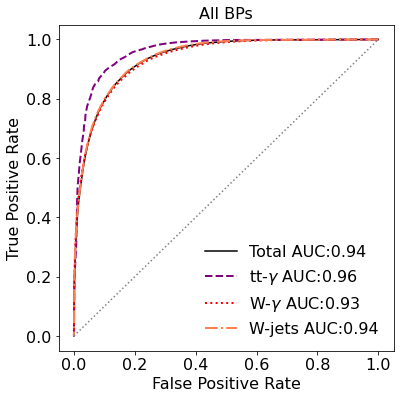

In [491]:
plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.plot(fpr_total, tpr_total, c = 'black', label = 'Total AUC:{:.2f}'.format(auc_total))
plt.plot(fpr_ttgamma, tpr_ttgamma, c = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$ AUC:{:.2f}'.format(auc_ttgamma))
plt.plot(fpr_wgamma, tpr_wgamma, c = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$ AUC:{:.2f}'.format(auc_wgamma))
plt.plot(fpr_wjets, tpr_wjets, c = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets AUC:{:.2f}'.format(auc_wjets))
plt.legend(frameon=False,fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.xlabel("False Positive Rate",fontsize=16)
plt.plot([0,1],[0,1],ls=":",color="grey")
plt.title(r"All BPs",fontsize=16)

plt.savefig('../graph/ROC_AllVars_AllBPs_MET200_new.png', bbox_inches='tight')

In [492]:
# Let's estimate the ROC Curve
nvals = 50
tpr_total   = np.zeros(nvals) 
fpr_total   = np.zeros(nvals) 
tpr_ttgamma = np.zeros(nvals) 
fpr_ttgamma = np.zeros(nvals) 
tpr_wgamma  = np.zeros(nvals) 
fpr_wgamma  = np.zeros(nvals) 
tpr_wjets   = np.zeros(nvals) 
fpr_wjets   = np.zeros(nvals) 

tpr_bps = np.zeros((15, nvals))
fpr_bps = np.zeros((15, nvals))
for ith, th in enumerate(np.linspace(0,1, nvals)):
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_total[ith] = len(tp) / (len(tp) + len(fn))
    fpr_total[ith] = len(fp) / (len(fp) + len(tn))
    
  
    for bp in BPS_analyzed:
        tp = np.where( (df_test_array[:,24] == (bp+1)) & (y_pred_xg > th) )[0]
        fn = np.where( (df_test_array[:,24] == (bp+1)) & (y_pred_xg < th) )[0]
        tpr_bps[bp, ith] = len(tp) / (len(tp) + len(fn))
        fpr_bps[bp, ith] = len(fp) / (len(fp) + len(tn))
        
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))

        
        
auc_total   = auc(fpr_total, tpr_total)
auc_wgamma  = auc(fpr_wgamma, tpr_wgamma)
auc_wjets   = auc(fpr_wjets, tpr_wjets)
auc_ttgamma = auc(fpr_ttgamma, tpr_ttgamma)

auc_bps = []
for bp in np.arange(15):
    auc_bps.append( auc(fpr_bps[bp,:], tpr_bps[bp,:]) )
    
auc_bps = np.asarray(auc_bps)

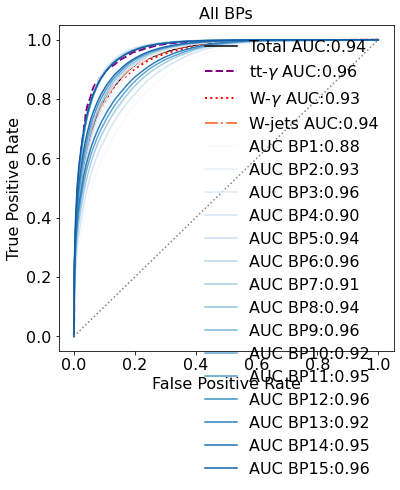

In [493]:
cmap = cm.get_cmap('Blues', 18)

plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.plot(fpr_total, tpr_total, c = 'black', label = 'Total AUC:{:.2f}'.format(auc_total))
plt.plot(fpr_ttgamma, tpr_ttgamma, c = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$ AUC:{:.2f}'.format(auc_ttgamma))
plt.plot(fpr_wgamma, tpr_wgamma, c = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$ AUC:{:.2f}'.format(auc_wgamma))
plt.plot(fpr_wjets, tpr_wjets, c = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets AUC:{:.2f}'.format(auc_wjets))

for bp in BPS_analyzed:
    plt.plot(fpr_bps[bp,:], tpr_bps[bp,:], c = cmap(bp), label = 'AUC BP{:}:{:.2f}'.format((bp+1),auc_bps[bp]))

    
plt.legend(frameon=False,fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.xlabel("False Positive Rate",fontsize=16)
plt.plot([0,1],[0,1],ls=":",color="grey")
plt.title(r"All BPs",fontsize=16)

plt.savefig('../graph/ROC_AllVars_AllBPs_MET200_new.png', bbox_inches='tight')

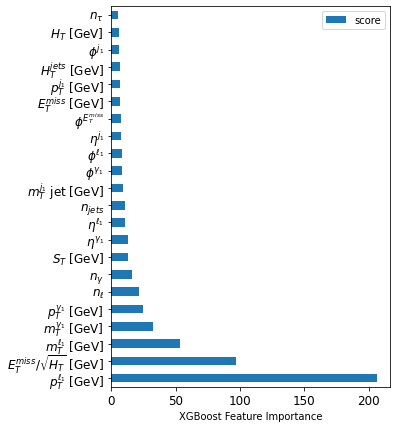

In [494]:
lst1 = ['$p_T^{\gamma_1}$ [GeV]', '$\eta^{\gamma_1}$', '$\phi^{\gamma_1}$', '$n_\gamma$',
       '$p_T^{j_1}$ [GeV]', '$\eta^{j_1}$', '$\phi^{j_1}$',
       '$p_T^{\ell_1}$ [GeV]', '$\eta^{\ell_1}$', '$\phi^{\ell_1}$', '$n_\ell$', '$n_{\\tau}$',
       '$E_T^{miss}$ [GeV]', '$\phi^{E_T^{miss}}$',
       '$H_T$ [GeV]', '$H_T^{jets}$ [GeV]', '$n_{jets}$',
       '$S_T$ [GeV]', 
       '$E_T^{miss}/\sqrt{H_T}$ [GeV]',
       '$m_T^{\gamma_1}$ [GeV]', '$m_T^{j_{1}}$ jet [GeV]', '$m_T^{\ell_1}$ [GeV]',
       'SM=0 - NP=1']

fig, ax = plt.subplots(figsize = (5,7))

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(len(lst) - 1, columns="score").plot(kind='barh', ax = ax) ## plot top 20 features

ax.set_xlabel("XGBoost Feature Importance")
ax.set_yticklabels(np.asarray(lst1)[np.argsort(values)[::-1]])

plt.savefig('../graph/AllBps_featureImportance_All_MET200_new.pdf', bbox_inches='tight')

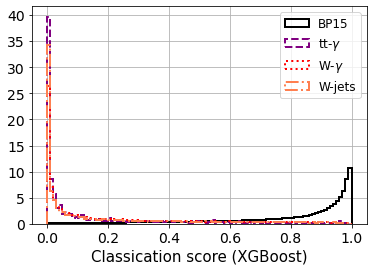

In [495]:
plt.hist(y_pred_xg[np.where(bkg_flag_test == 0)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = 'black', label = 'BP' + str(bp + 1), lw = 2)
plt.hist(y_pred_xg[np.where(bkg_flag_test == 3)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 1)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 2)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
#plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('../graph/MLOutput_dist_AllVars_AllBPs_MET200_new.png', bbox_inches="tight")

In [496]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

In [497]:
len(np.where(bkg_flag_test != 0)[0])

52534

In [498]:
len(np.where(bkg_flag_test == 0)[0])

1477479

## Sequential selection criteria

In [532]:
nbins = 10
indices_aux = np.arange(len(df_test_array))

n_np0 = []
for bp in np.arange(15):
    n_np0.append( len(np.where(df_test_array[:, 24] == (bp+1))[0]) )
    
n_wgamma0  = len(np.where(df_test_array[:, 22] == 1)[0])
n_wjets0   = len(np.where(df_test_array[:, 22] == 2)[0])
n_ttgamma0 = len(np.where(df_test_array[:, 22] == 3)[0])
n_ttjets0  = len(np.where(df_test_array[:, 22] == 4)[0])
n_zjets0   = len(np.where(df_test_array[:, 22] == 5)[0])
n_wz0      = len(np.where(df_test_array[:, 22] == 6)[0])
n_zz0      = len(np.where(df_test_array[:, 22] == 7)[0])
n_ww0      = len(np.where(df_test_array[:, 22] == 8)[0])
n_tj0      = len(np.where(df_test_array[:, 22] == 9)[0])
n_tb0      = len(np.where(df_test_array[:, 22] == 10)[0])
n_tw0      = len(np.where(df_test_array[:, 22] == 11)[0])

sup_cuts = {}
inf_cuts = {}
random_vars = np.random.choice(range(len(df_test.columns) - 3), size = 100, replace = True)
random_vars = np.concatenate((np.random.choice(range(len(df_test.columns) - 3), size = len(df_test.columns) - 3, replace = False), random_vars))
#random_vars = list(np.argsort(values)[::-1])*10

for ivar in random_vars:
    #print(indices_aux)
    cuts = np.linspace(np.min(df_test_array[indices_aux,ivar]), np.max(df_test_array[indices_aux,ivar]), nbins)
    ZN_sup = np.zeros(nbins)
    ZN_inf = np.zeros(nbins)

    indices = []
    Z = []
    for icut, cut in enumerate(cuts): 
        
        # Superior ------------------------------------------------------------------------------------
        indices_sup = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cut) )[0]]
        indices.append(indices_sup)
        
        n_wgamma  = len(np.where(df_test_array[indices_sup, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_sup, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_sup, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_sup, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_sup, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_sup, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_sup, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_sup, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_sup, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_sup, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_sup, 22] == 11)[0])
        
        wgamma_expected  = Wgamma_cross * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = Wjets_cross * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)
        ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
        zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
        wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
        zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
        ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
        tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
        tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
        tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)
        
        S_expected_aux = np.zeros(15)
        for bp in np.arange(15):
            n_np = len(np.where( (df_test_array[indices_sup, 24] == (bp+1)) )[0])
            S_expected_aux[bp] = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0[bp]))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                             zjets_expected + wz_expected + zz_expected + ww_expected + \
                             tj_expected + tb_expected + tw_expected)
        #if B_expected > 5: Z_sup[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and ( np.min(S_expected_aux) > 5):
            Z_norm = np.zeros(15)
            for bp in np.arange(15):
                Z_norm[bp] = np.sqrt(2 * ((B_expected_aux + S_expected_aux[bp]) * np.log(1 + S_expected_aux[bp] / B_expected_aux) - S_expected_aux[bp]))
                Z_norm[bp] = Z_norm[bp] / S_expected[bp]
            ZN_sup[icut] = np.mean(Z_norm)
            Z.append( ZN_sup[icut] )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------

        # Inferior ------------------------------------------------------------------------------------
        indices_inf = indices_aux[np.where( (df_test_array[indices_aux,ivar] <= cut) )[0]]
        indices.append(indices_inf)
        
        n_np      = len(np.where(df_test_array[indices_inf, 22] == 0)[0])
        n_wgamma  = len(np.where(df_test_array[indices_inf, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_inf, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_inf, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_inf, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_inf, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_inf, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_inf, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_inf, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_inf, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_inf, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_inf, 22] == 11)[0])

        wgamma_expected  = Wgamma_cross * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = Wjets_cross * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)
        ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
        zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
        wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
        zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
        ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
        tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
        tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
        tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

        S_expected_aux = np.zeros(15)
        for bp in np.arange(15):
            n_np = len(np.where( (df_test_array[indices_inf, 24] == (bp+1)) )[0])
            S_expected_aux[bp] = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0[bp]))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                             zjets_expected + wz_expected + zz_expected + ww_expected + \
                             tj_expected + tb_expected + tw_expected)
        
        #if B_expected > 5: Z_inf[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (np.min(S_expected_aux) > 5):
            Z_norm = np.zeros(15)
            for bp in np.arange(15):
                Z_norm[bp] = np.sqrt(2 * ((B_expected_aux + S_expected_aux[bp]) * np.log(1 + S_expected_aux[bp] / B_expected_aux) - S_expected_aux[bp]))
                Z_norm[bp] = Z_norm[bp] / S_expected[bp]
            ZN_inf[icut] = np.mean(Z_norm)
            Z.append( ZN_inf[icut] )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------
    max_cut     = np.argmax(np.asarray(Z))
    indices_aux = indices[max_cut]
    max_cut     = np.argmax((ZN_inf, ZN_sup))
    if max_cut >= len(ZN_inf):
        print(df_test.columns[ivar] + ' >= ' + str(cuts[max_cut - len(ZN_sup)]) + '; <Z Norm> = ' + str(ZN_sup[max_cut - len(ZN_inf)]))
        if df.columns[ivar] in inf_cuts.keys():
            inf_cuts[df_test.columns[ivar]] = cuts[max_cut - len(ZN_sup)]
        inf_cuts.setdefault(df_test.columns[ivar], cuts[max_cut - len(ZN_sup)])
        sup_cuts.setdefault(df_test.columns[ivar], 999999)
    else:
        print(df_test.columns[ivar] + ' <= ' + str(cuts[max_cut]) + '; <Z Norm> = ' + str(ZN_inf[max_cut]))
        if df.columns[ivar] in sup_cuts.keys():
            sup_cuts[df_test.columns[ivar]] = cuts[max_cut]
        sup_cuts.setdefault(df_test.columns[ivar], cuts[max_cut])
        inf_cuts.setdefault(df_test.columns[ivar], -999999)   
    
n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

wgamma_expected  = Wgamma_cross * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = Wjets_cross * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)
ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

S_expected_aux = np.zeros(15)
for bp in np.arange(15):
    n_np = len(np.where( (df_test_array[indices_inf, 24] == (bp+1)) )[0])
    S_expected_aux[bp] = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0[bp]))
    
# Formula discovery
B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                     zjets_expected + wz_expected + zz_expected + ww_expected + \
                     tj_expected + tb_expected + tw_expected)
if (B_expected_aux > 5) and (np.min(S_expected_aux) > 5): 
    for bp in np.arange(15):
        print('\n')
        print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux[bp]) * np.log(1 + S_expected_aux[bp] / B_expected_aux) - S_expected_aux[bp])))
        print('Expected Background = ' + str(B_expected_aux))
        print('Expected Signal = ' + str(S_expected_aux[bp]))

jet $\phi$ <= 3.142; <Z Norm> = 0.006152189919451709
num lepton <= 1.0; <Z Norm> = 0.006199780313593619
MET $p_T$ [GeV] <= 2279.188888888889; <Z Norm> = 0.006199780313593619
lepton $p_T$ [GeV] <= 184.92888888888888; <Z Norm> = 0.00652765461799431
num photon <= 2.111111111111111; <Z Norm> = 0.006527936307390803
$S_T$ [GeV] <= 2486.362222222222; <Z Norm> = 0.006528218033362496
$H_T$ [GeV] <= 4162.52; <Z Norm> = 0.00652835890986273
jet $\eta$ <= 4.371; <Z Norm> = 0.00652835890986273
num_taus <= 2.0; <Z Norm> = 0.00652835890986273
$m_T$ photon [GeV] <= 350.7659673667592; <Z Norm> = 0.006593044020383967
lepton $\phi$ <= 3.142; <Z Norm> = 0.006593044020383967
MET sig [GeV] >= 11.437945490086046; <Z Norm> = 0.008201533713242738
MET $\phi$ <= 3.142; <Z Norm> = 0.008201533713242738
photon $p_T$ [GeV] <= 222.32666666666665; <Z Norm> = 0.008212334447121125
jet $p_T$ [GeV] <= 2402.5; <Z Norm> = 0.008212334447121125
photon $\phi$ <= 3.142; <Z Norm> = 0.008212334447121125
photon $\eta$ <= 2.369; <Z 

In [525]:
sup_cuts

{'jet $p_T$ [GeV]': 1692.86,
 'lepton $p_T$ [GeV]': 36.86,
 '$m_T$ lepton [GeV]': 279.8090955842221,
 'photon $\\phi$': 3.142,
 '$H_T$ [GeV]': 2466.3744444444446,
 'jet $\\eta$': 4.294,
 'MET $p_T$ [GeV]': 1303.38,
 'num_taus': 1.1111111111111112,
 '$m_T$ jet [GeV]': 2881.1469797788914,
 'MET sig [GeV]': 31.939185546423705,
 'photon $\\eta$': 2.369,
 '$H_T$ (jets) [GeV]': 2332.81,
 'lepton $\\eta$': 2.5,
 'num_jets': 10.777777777777779,
 'jet $\\phi$': 3.142,
 'num lepton': 3.0,
 'lepton $\\phi$': 3.142,
 'photon $p_T$ [GeV]': 199.47,
 '$S_T$ [GeV]': 1808.8500000000001,
 'MET $\\phi$': 3.142,
 'num photon': 2.111111111111111,
 '$m_T$ photon [GeV]': 305.2188511579245}

In [526]:
inf_cuts

{'jet $p_T$ [GeV]': -999999,
 'lepton $p_T$ [GeV]': -999999,
 '$m_T$ lepton [GeV]': -999999,
 'photon $\\phi$': -999999,
 '$H_T$ [GeV]': -999999,
 'jet $\\eta$': -999999,
 'MET $p_T$ [GeV]': -999999,
 'num_taus': -999999,
 '$m_T$ jet [GeV]': -999999,
 'MET sig [GeV]': 11.674538667743967,
 'photon $\\eta$': -1.8425555555555557,
 '$H_T$ (jets) [GeV]': -999999,
 'lepton $\\eta$': -999999,
 'num_jets': -999999,
 'jet $\\phi$': -999999,
 'num lepton': -999999,
 'lepton $\\phi$': -999999,
 'photon $p_T$ [GeV]': -999999,
 '$S_T$ [GeV]': -999999,
 'MET $\\phi$': -999999,
 'num photon': -999999,
 '$m_T$ photon [GeV]': 37.62994601741262}

In [527]:
write = True
if write:
    with open('../data/cuts/ALLBPs_supCuts_MET200_new.txt', "w") as fp:
        json.dump(sup_cuts, fp)

    with open('../data/cuts/ALLBPs_infCuts_MET200_new.txt', "w") as fp:
        json.dump(inf_cuts, fp)
else:
    with open('../data/cuts/ALLBPs_supCuts_MET200_new.txt', "r") as fp:
        # Load the dictionary from the file
        sup_cuts = json.load(fp)
    with open('../data/cuts/ALLBPs_infCuts_MET200_new.txt', "r") as fp:
        # Load the dictionary from the file
        inf_cuts = json.load(fp)

100%|██████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 275.67it/s]


Final results: for BP 1
 
Z = 0.6258516249842359; Z_std = 0.10941144830371663
B_exp = 2924.395; B_exp_std = 40.695908578135956
S_exp = 33.9355; S_exp_std = 5.805630004573147


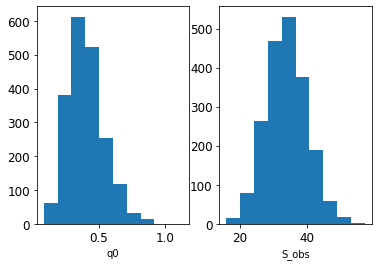

100%|██████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 269.02it/s]


Final results: for BP 2
 
Z = 2.060215621945993; Z_std = 0.19701481749113164
B_exp = 2925.746; B_exp_std = 40.40265441774835
S_exp = 112.4285; S_exp_std = 10.646073818549258


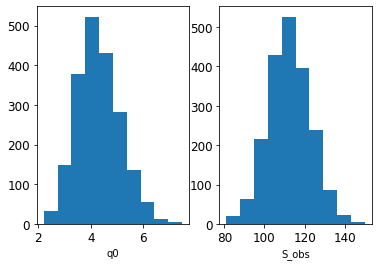

100%|██████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 260.92it/s]


Final results: for BP 3
 
Z = 4.120420162970797; Z_std = 0.2758229638429084
B_exp = 2923.9555; B_exp_std = 40.64212740187206
S_exp = 225.6405; S_exp_std = 15.146064166970904


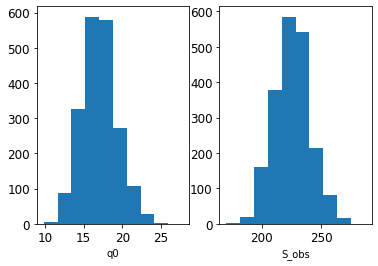

100%|██████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 267.06it/s]


Final results: for BP 4
 
Z = 0.40407308621223914; Z_std = 0.08925994682281466
B_exp = 2925.626; B_exp_std = 40.35419586610543
S_exp = 22.027; S_exp_std = 4.644488238762157


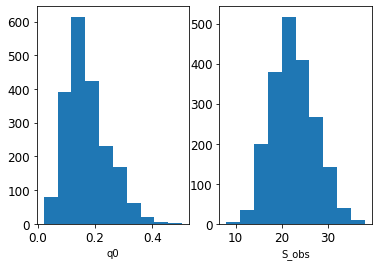

100%|██████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 264.72it/s]


Final results: for BP 5
 
Z = 1.1683859936126806; Z_std = 0.15007461618214477
B_exp = 2926.2135; B_exp_std = 40.12448028012326
S_exp = 63.6765; S_exp_std = 8.029934479807416


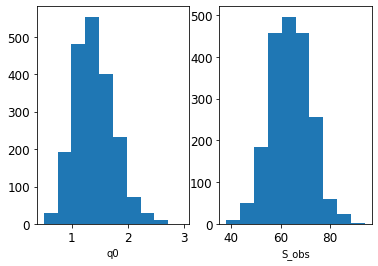

100%|██████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 248.00it/s]


Final results: for BP 6
 
Z = 2.138484491957117; Z_std = 0.2032630472992043
B_exp = 2925.496; B_exp_std = 40.9631661862215
S_exp = 116.455; S_exp_std = 10.989448348302112


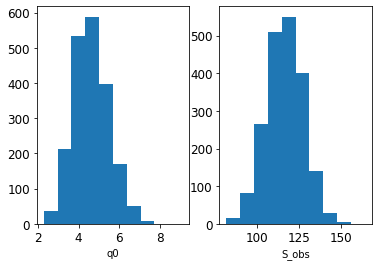

100%|██████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 261.80it/s]

Final results: for BP 7
 
Z = 0.26129852942962806; Z_std = 0.07471745766877565
B_exp = 2926.4085; B_exp_std = 40.25781449296521
S_exp = 14.5135; S_exp_std = 3.764547482766023


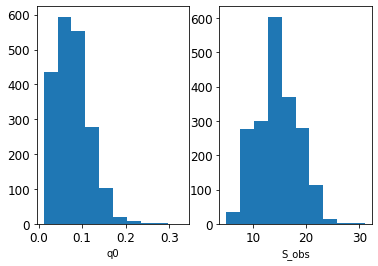

100%|██████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 261.74it/s]


Final results: for BP 8
 
Z = 0.6831608288650237; Z_std = 0.11303268002797004
B_exp = 2925.407; B_exp_std = 40.74677104998628
S_exp = 37.2155; S_exp_std = 5.984484919356051


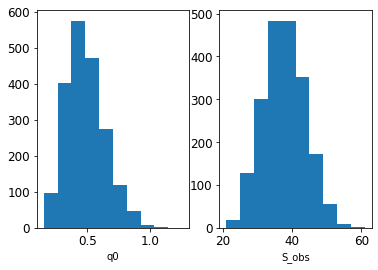

100%|██████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 266.40it/s]


Final results: for BP 9
 
Z = 1.160430525913744; Z_std = 0.14508176649361731
B_exp = 2925.2805; B_exp_std = 39.66786885818294
S_exp = 63.034; S_exp_std = 7.82277725619233


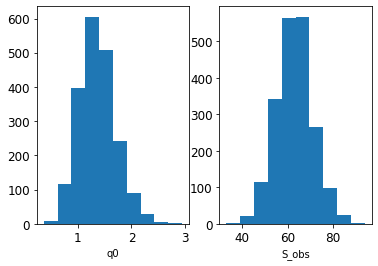

100%|██████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 276.16it/s]


Final results: for BP 10
 
Z = 0.18444875140289121; Z_std = 0.05682073981549366
B_exp = 2923.4865; B_exp_std = 39.99059661657975
S_exp = 9.675; S_exp_std = 3.106827159659835


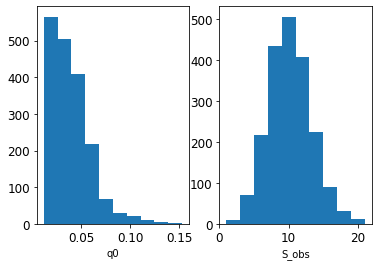

100%|██████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 277.19it/s]


Final results: for BP 11
 
Z = 0.42241625910794645; Z_std = 0.09354809171375802
B_exp = 2924.287; B_exp_std = 40.986969038951884
S_exp = 22.8525; S_exp_std = 4.906907758456439


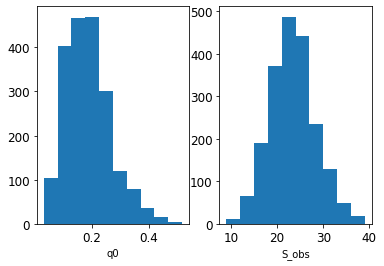

100%|██████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 275.91it/s]


Final results: for BP 12
 
Z = 0.6682181163620744; Z_std = 0.11805061635322996
B_exp = 2924.8405; B_exp_std = 41.21202566909324
S_exp = 36.5545; S_exp_std = 6.1698484381709084


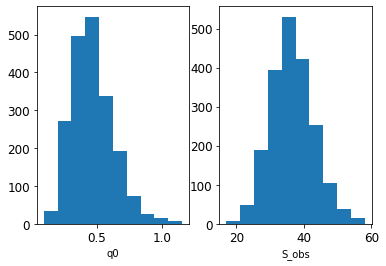

100%|██████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 278.88it/s]


Final results: for BP 13
 
Z = 0.1302603098673178; Z_std = 0.03912822851448018
B_exp = 2926.032; B_exp_std = 40.95929657599115
S_exp = 5.8845; S_exp_std = 2.4345758870899874


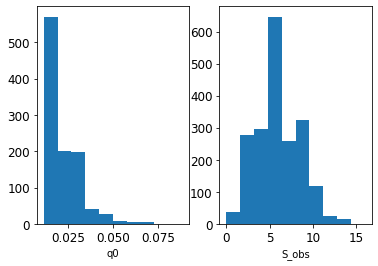

100%|██████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 279.41it/s]


Final results: for BP 14
 
Z = 0.24047986253042059; Z_std = 0.06696263558533946
B_exp = 2923.9625; B_exp_std = 40.55476659715846
S_exp = 13.135; S_exp_std = 3.488233793770137


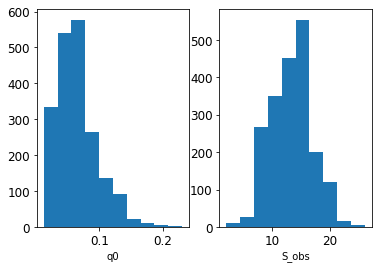

100%|██████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 276.94it/s]


Final results: for BP 15
 
Z = 0.386937124657212; Z_std = 0.08633143667408619
B_exp = 2924.3055; B_exp_std = 41.36472131841335
S_exp = 21.0235; S_exp_std = 4.5441113267612625


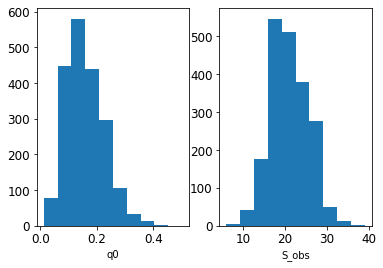

In [528]:
nexperiments = 2000

SM_test_pool = np.where(df_test_array[:,22] > 0)[0]

for bp in np.arange(15):
    
    NP_test_pool = np.where(df_test_array[:,24] == (bp+1))[0]

    q0_exp = np.zeros(nexperiments)
    B_observed_exp = np.zeros(nexperiments)
    S_observed_exp = np.zeros(nexperiments)
    for nexp in tqdm(range(nexperiments)):
        # Let's create a pseudo-experiment
        SM_indices = np.random.choice(SM_test_pool, size = np.random.poisson(int(B_expected)), replace = False)
        NP_indices = np.random.choice(NP_test_pool, size = np.random.poisson(int(S_expected[bp])), replace = False)
        indices_aux = np.concatenate((NP_indices, SM_indices))

        # Let's make the cuts

        variables = list(sup_cuts.keys())
        for i in range(len(variables)):
            ind_var = np.where(df_test.columns == variables[i])[0][0]
            indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                                    (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                                   )[0]]
        # Let's calculate everything

        n_np = len(np.where(df_test_array[indices_aux, 24] == (bp+1))[0])

        n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

        S_observed_exp[nexp] = n_np

        # Formula discovery
        B_observed_exp[nexp] = n_ttgamma + n_wgamma + n_wjets + \
                               n_ttjets + n_zjets + n_wz + \
                               n_zz + n_ww + n_tj + \
                               n_tb + n_tw
        
        N_observed = n_np + n_ttgamma + n_wgamma + n_wjets+ \
                     n_ttjets + n_zjets + n_wz + \
                     n_zz + n_ww + n_tj + \
                     n_tb + n_tw
        
        if (B_observed_exp[nexp] >= 5) and (n_np > 5): 
            q0_exp[nexp] = -2 * N_observed * np.log(B_observed_exp[nexp] / N_observed) -2 * (N_observed - B_observed_exp[nexp])
        else:
            q0_exp[nexp] = -99
            
    q0_exp = q0_exp[np.where(q0_exp > 0)[0]]
    print('Final results: for BP ' + str(bp+1) + '\n ')
    print('Z = ' + str(np.sqrt(np.median(q0_exp))) + '; Z_std = ' + str(np.std(q0_exp) / (2 * np.sqrt(np.median(q0_exp)))))
    print('B_exp = ' + str(np.mean(B_observed_exp)) + '; B_exp_std = ' + str(np.std(B_observed_exp)))
    print('S_exp = ' + str(np.mean(S_observed_exp)) + '; S_exp_std = ' + str(np.std(S_observed_exp)))
    fig,ax = plt.subplots(1,2)
    
    ax[0].hist(q0_exp)
    ax[0].set_xlabel('q0')
    ax[1].hist(S_observed_exp)
    ax[1].set_xlabel('S_obs')
    plt.show()

In [529]:
imp_vars = np.asarray(lst)[np.argsort(values)[::-1]][:4]

In [530]:
imp_vars

array(['lepton $p_T$ [GeV]', 'MET sig [GeV]', '$m_T$ lepton [GeV]',
       '$m_T$ photon [GeV]'], dtype='<U18')

In [174]:
imp_vars_labels = ['$p_T^{\ell_{1}}$', '$E_T^{miss}/\sqrt{H_T}$','$m_T^{\ell_1}$',  '$m_T^{\gamma_1}$']

In [175]:
NP_cmap = create_cyan_to_black_cmap('black', mcolors.to_rgb('white'), cmap_name = 'NP_cmap')

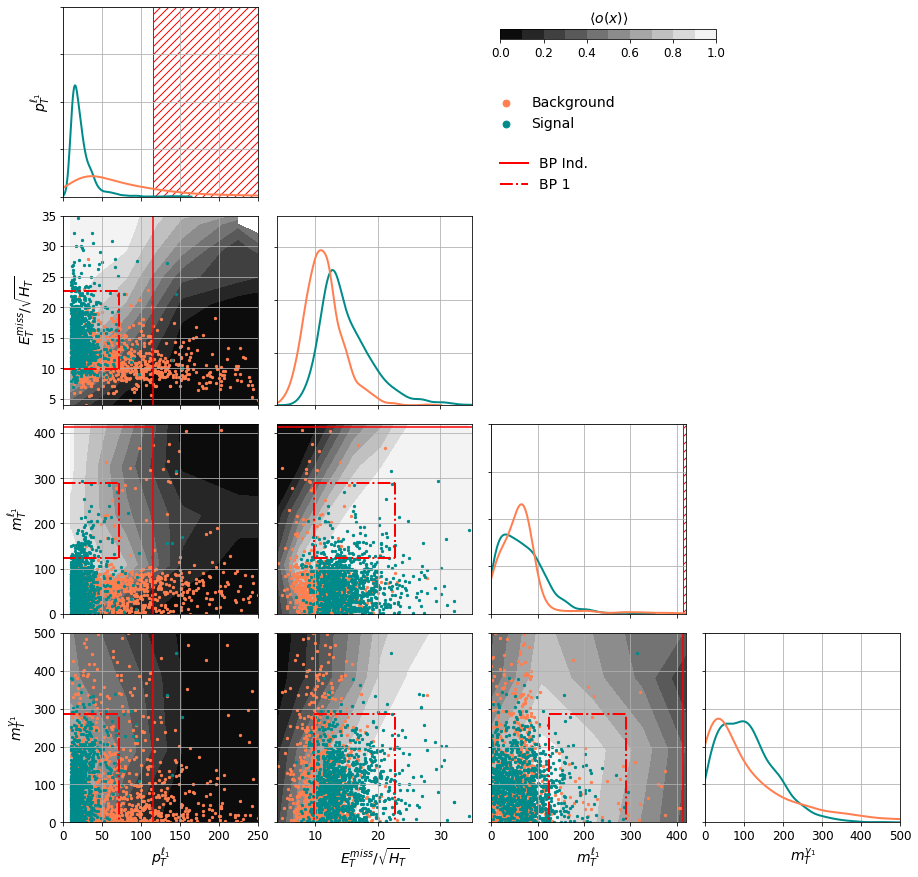

In [176]:
SM = df_test.loc[df_test['bkg_flag_pool'] != 0]
NP = df_test.loc[df_test['bkg_flag_pool'] == 0]

pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

rand_ind = np.random.choice(range(len(NP)), size =  1000, replace = False)
NP = NP.iloc[rand_ind]
pred_XG_NP = pred_XG_NP[rand_ind]

rand_ind = np.random.choice(range(len(SM)), size =  1000, replace = False)
SM = SM.iloc[rand_ind]
pred_XG_SM = pred_XG_SM[rand_ind]

#limites = [[4,35], [0,250], [0,420], [0,500]]
limites = [[0,250], [4,35], [0,420], [0,500]]
ylimites = [[0,0.08], [0,0.18], [0,0.02], [0,0.01]]
#ylimites = [[0,0.18], [0,0.12], [0,0.03], [0,0.01]]

rand_ind = np.random.choice(range(len(df_test)), size =  len(df_test), replace = False)
aux = df_test.iloc[rand_ind]
y_pred_aux = y_pred_xg[rand_ind]

with open('../data/cuts/ALLBPs_supCuts_MET200_new.txt', "r") as fp:
    # Load the dictionary from the file
    sup_cuts = json.load(fp)
with open('../data/cuts/ALLBPs_infCuts_MET200_new.txt', "r") as fp:
    # Load the dictionary from the file
    inf_cuts = json.load(fp)
        
fig,ax = plt.subplots(4,4, figsize = (15,15), gridspec_kw={'hspace':0.1, 'wspace':0.1})

for i in range(4):
    for j in range(4):
        if i != 3: ax[i,j].set_xticklabels([])
        if j != 0: ax[i,j].set_yticklabels([])
        if i >= j:
            if i==j:
                sns.kdeplot(NP[imp_vars[i]], ax = ax[i,j], color = 'darkcyan', lw=2, ls = 'solid')
                sns.kdeplot(SM[imp_vars[i]], ax = ax[i,j], color = 'coral', lw=2, ls = 'solid')
                ax[i,j].set_ylabel('')
                ax[i,j].set_xlabel('')
                ax[i,j].set_xlim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = sup_cuts[imp_vars[i]], x2 = 1000, facecolor = 'none', edgecolor = 'red', zorder = 0, hatch = '///')
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = -1, x2 = inf_cuts[imp_vars[i]], facecolor = 'none', edgecolor = 'red', zorder = 0, hatch = '///')
                ax[i,j].set_ylim(ylimites[i])
            else:
                stats, xedge, yedge, _ = binned_statistic_2d(aux[imp_vars[j]], aux[imp_vars[i]], y_pred_aux, bins = 22)
                im_NP = ax[i,j].contourf(xedge[:-1], yedge[:-1], stats.T, cmap=NP_cmap, zorder = 0, levels = np.linspace(0,1,11))
                ax[i,j].scatter(SM[imp_vars[j]], SM[imp_vars[i]], s = 20.8, marker = '.', 
                                        c = 'coral', rasterized=True, label = 'Background')
                ax[i,j].scatter(NP[imp_vars[j]], NP[imp_vars[i]], s = 20.8, marker = '.', 
                                        c = 'darkcyan', rasterized=True, label = 'Signal')
                ax[i,j].set_xlim(SM[imp_vars[j]].min(), SM[imp_vars[j]].max())
                ax[i,j].set_ylim(SM[imp_vars[i]].min(), SM[imp_vars[i]].max())
                ax[i,j].set_xlim(limites[j])
                ax[i,j].set_ylim(limites[i])
                #ax[i,j].fill_betweenx(y = [-1, 10000], x1 = sup_cuts[imp_vars[j]], x2 = 1000, color = 'silver', zorder = 1)
                #ax[i,j].fill_betweenx(y = [-1, 10000], x1 = -1, x2 = inf_cuts[imp_vars[j]], color = 'silver', zorder = 1)
                #ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = sup_cuts[imp_vars[i]], y2 = 1000, color = 'silver', zorder = 1)
                #ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = -1, y2 = inf_cuts[imp_vars[i]], color = 'silver', zorder = 1)
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], inf_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[sup_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], inf_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([sup_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')

                #%if (i==1) & (j==0):
                #%    # Create 2D interpolation function
                #%    x = xedge[:-1] + (xedge[1] - xedge[0])/2
                #%    y = yedge[:-1] + (yedge[1] - yedge[0])/2
                #%    x_new = np.linspace(limites[j][0], limites[j][1], 10000)
                #%    y_new = np.linspace(limites[i][0], limites[i][1], 10000)
                #%    X_new, Y_new = np.meshgrid(x_new, y_new)

                    # Interpolate values on the finer grid
                #%    f = bisplrep(aux[imp_vars[j]][:100000], aux[imp_vars[i]][:100000], y_pred_aux[:100000],kx=2,ky=2)
                #%    Z_new = bisplev(x_new, y_new,f)

                #%    ax[i,j].contourf(x_new, y_new, Z_new.T,cmap=NP_cmap,levels=np.linspace(0,1,10),zorder=1)

                
            ax[i,j].grid(which = 'both')
        else:
            ax[i,j].axis('off')

ax[3,0].set_xlabel(imp_vars_labels[0], fontsize = 14)
ax[3,1].set_xlabel(imp_vars_labels[1], fontsize = 14)
ax[3,2].set_xlabel(imp_vars_labels[2], fontsize = 14)
ax[3,3].set_xlabel(imp_vars_labels[3], fontsize = 14)

ax[0,0].set_ylabel(imp_vars_labels[0], fontsize = 14)
ax[1,0].set_ylabel(imp_vars_labels[1], fontsize = 14)
ax[2,0].set_ylabel(imp_vars_labels[2], fontsize = 14)
ax[3,0].set_ylabel(imp_vars_labels[3], fontsize = 14)

ax[0,0].set_xticklabels([])

ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])

ax[2,2].set_yticklabels([])
ax[2,2].set_xticklabels([])

ax[3,3].set_yticklabels([])
ax[0,0].set_yticklabels([])



with open('../data/cuts/BP1_supCuts_MET200.txt', "r") as fp:
    # Load the dictionary from the file
    sup_cuts = json.load(fp)
with open('../data/cuts/BP1_infCuts_MET200.txt', "r") as fp:
    # Load the dictionary from the file
    inf_cuts = json.load(fp)

for i in range(4):
    for j in range(4):
        if i >= j:
            if i==j:
                pass
                #ax[i,j].fill_betweenx(y = [-1, 1], x1 = sup_cuts[imp_vars[i]], x2 = 1000, color = 'silver', zorder = 0)
                #ax[i,j].fill_betweenx(y = [-1, 1], x1 = -1, x2 = inf_cuts[imp_vars[i]], color = 'silver', zorder = 0)
            else:
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], inf_cuts[imp_vars[i]]], color = 'red', ls = '-.', lw = 2) 
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[sup_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red', ls = '-.', lw = 2) 
                ax[i,j].plot([inf_cuts[imp_vars[j]], inf_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red', ls = '-.', lw = 2) 
                ax[i,j].plot([sup_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red', ls = '-.', lw = 2) 


# Legends------------------------------------------

ax[1,0].legend(loc = 'upper right', bbox_to_anchor=(2.9, 1.7), fontsize = 14, frameon = False, markerscale=3)

#%cbar_SM = plt.colorbar(im_SM, ax = ax[0,2], orientation = 'horizontal', pad = 0.5)
#%cbar_SM.set_label('$P(S|B)$', labelpad=-50)
cax = fig.add_axes([0.53, 0.85, 0.2, 0.01])
cbar_NP = plt.colorbar(im_NP, cax=cax, orientation = 'horizontal')
cbar_NP.set_label(r'$\langle o(x) \rangle$', labelpad=-50, fontsize = 14)

patch1 = mlines.Line2D([], [], color='red', label='BP Ind.', linestyle='-', markerfacecolor='none', markeredgewidth=2, lw = 2)
patch2 = mlines.Line2D([], [], color='red', label='BP 1', linestyle='-.', markerfacecolor='none', markeredgewidth=2, lw = 2)

# Add custom legend with boxes
ax[0,0].legend(handles=[patch1, patch2], loc = 'lower left', bbox_to_anchor=(2.18, -0.04), fontsize = 14, frameon = False )

#plt.savefig('../graph/ALLBPs_ImpVars_dist_MET200_BP1_new.pdf', bbox_inches='tight')

## BinnedLikelihood

In [499]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

In [500]:
print(pred_XG_SM.shape)
print(pred_XG_NP.shape)

(52534,)
(1477479,)


In [501]:
B_expected = int(B_expected)

B_expected:  26060

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


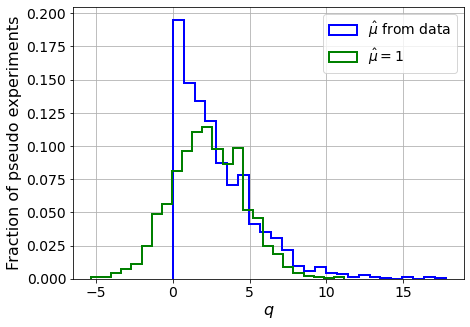

BP1

S_expected:  81.42521191306237
muhat mean:  1.0254
Z_bins:  1.500818755668051
std Z_bins:  0.82661860082298
Z_bins mu=1:  1.503092362081389
std Z_bins mu=1:  0.7721140633748921

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


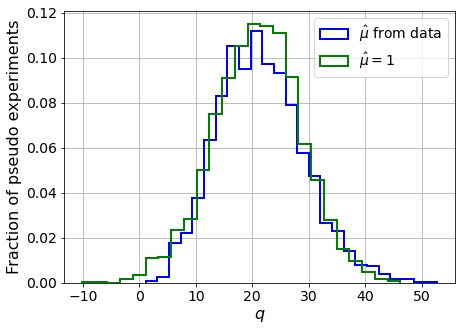

BP2

S_expected:  205.77130384387502
muhat mean:  1.019325
Z_bins:  4.60278281901291
std Z_bins:  0.8282458507847844
Z_bins mu=1:  4.6052093670113585
std Z_bins mu=1:  0.8375447286788281

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


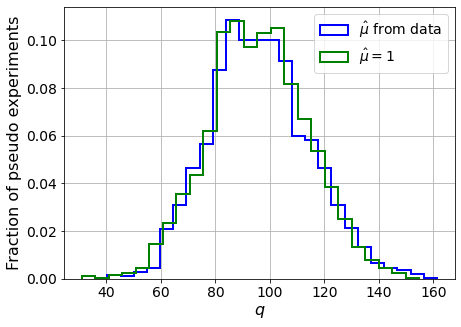

BP3

S_expected:  343.90174266306013
muhat mean:  1.027825
Z_bins:  9.765960587992073
std Z_bins:  0.930652347968657
Z_bins mu=1:  9.770510586688907
std Z_bins mu=1:  0.9264217326735671

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


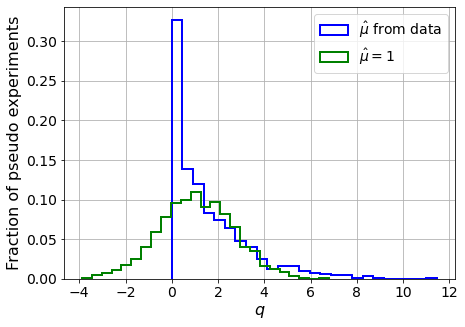

BP4

S_expected:  49.356859199999995
muhat mean:  0.9847500000000001
Z_bins:  1.0239579718330727
std Z_bins:  0.8180727771463836
Z_bins mu=1:  1.0324547746172978
std Z_bins mu=1:  0.7737186501766137

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


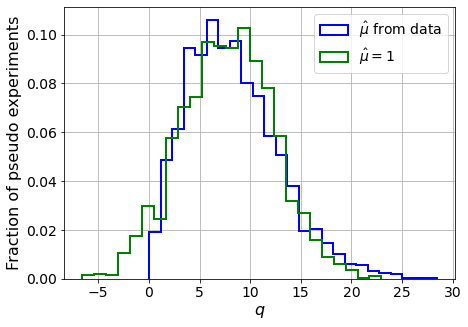

BP5

S_expected:  112.427180118
muhat mean:  1.0125250000000001
Z_bins:  2.792682718034346
std Z_bins:  0.8127979293826035
Z_bins mu=1:  2.7936619009113706
std Z_bins mu=1:  0.814718609388136

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


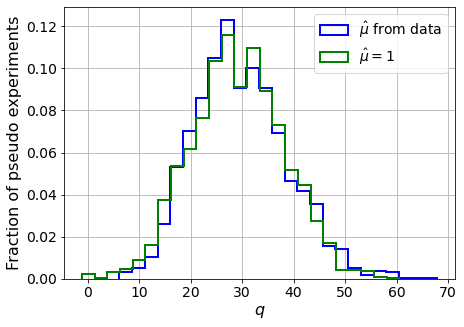

BP6

S_expected:  179.4753149145
muhat mean:  1.0251
Z_bins:  5.364907021139911
std Z_bins:  0.8380194761035255
Z_bins mu=1:  5.367089064848724
std Z_bins mu=1:  0.8351462122631819

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


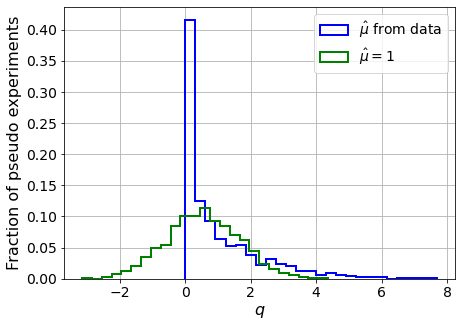

BP7

S_expected:  31.681197548000007
muhat mean:  0.9802750000000001
Z_bins:  0.719963830253484
std Z_bins:  0.8679868990741658
Z_bins mu=1:  0.7302070157632633
std Z_bins mu=1:  0.7749231372223858

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


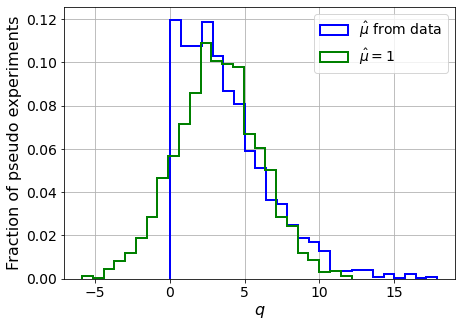

BP8

S_expected:  64.513952712
muhat mean:  1.0237
Z_bins:  1.7775360842075312
std Z_bins:  0.8172962459179658
Z_bins mu=1:  1.7805317737071098
std Z_bins mu=1:  0.7908813395563934

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


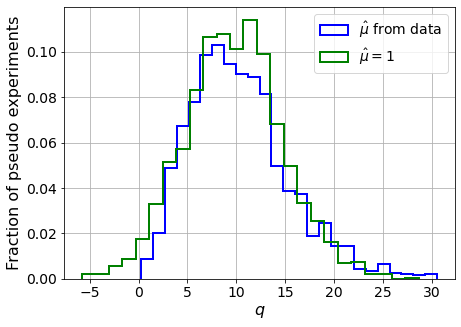

BP9

S_expected:  97.06617650400001
muhat mean:  1.0295
Z_bins:  3.1147971156975327
std Z_bins:  0.8106141770443149
Z_bins mu=1:  3.1147971156975327
std Z_bins mu=1:  0.7930881194093473

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


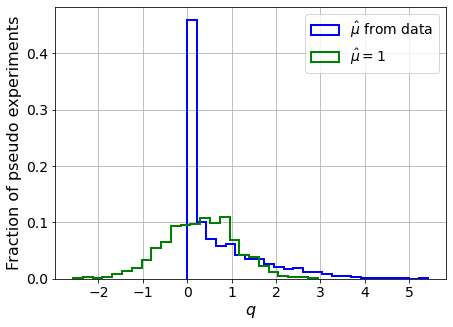

BP10

S_expected:  20.263040622000005
muhat mean:  1.0211750000000002
Z_bins:  0.5546783809952898
std Z_bins:  0.8300381643077995
Z_bins mu=1:  0.5649629338508821
std Z_bins mu=1:  0.7117046048101111

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


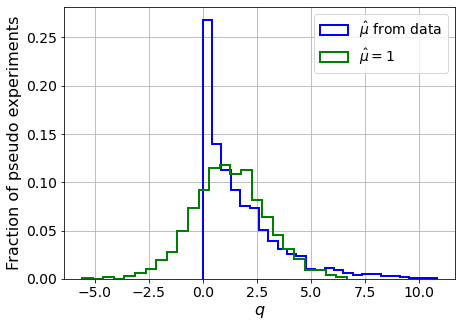

BP11

S_expected:  38.11102997624999
muhat mean:  0.9985
Z_bins:  1.0959511751692208
std Z_bins:  0.8300849351715572
Z_bins mu=1:  1.0966574625658372
std Z_bins mu=1:  0.7687767090382255

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


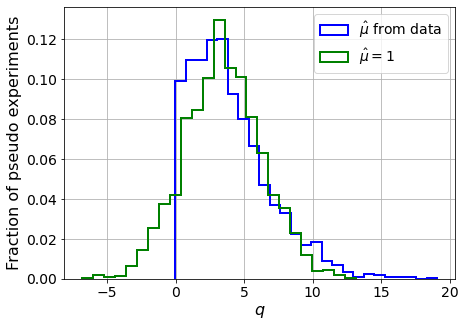

BP12

S_expected:  56.045856858749985
muhat mean:  1.0173250000000003
Z_bins:  1.8386337474110168
std Z_bins:  0.7924788526846198
Z_bins mu=1:  1.8386337474110168
std Z_bins mu=1:  0.7755045836676967

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


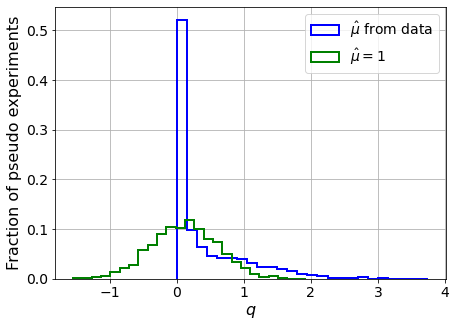

BP13

S_expected:  12.166326655999999
muhat mean:  1.0043
Z_bins:  0.34382978777793793
std Z_bins:  0.8538106861605963
Z_bins mu=1:  0.3533391598142951
std Z_bins mu=1:  0.6980072639545073

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


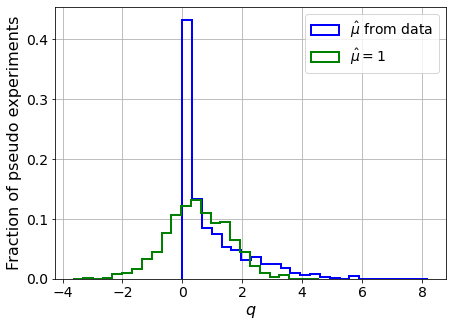

BP14

S_expected:  22.147437312
muhat mean:  1.007225
Z_bins:  0.703317912182819
std Z_bins:  0.8383914015859816
Z_bins mu=1:  0.7128914458914846
std Z_bins mu=1:  0.7385497385878224

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


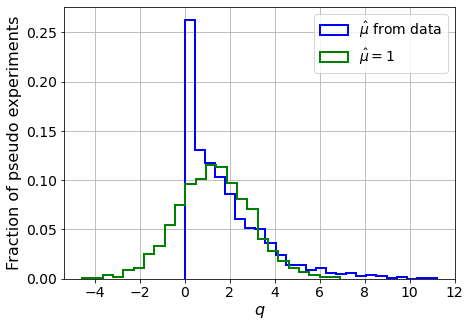

BP15

S_expected:  32.054438416
muhat mean:  1.0209
Z_bins:  1.1431793469864602
std Z_bins:  0.7767293532176021
Z_bins mu=1:  1.1450325198378746
std Z_bins mu=1:  0.7161795286966344

--------



In [502]:
D_or_E = 'discovery'
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]]
# requested number of pseudo experiments
num_pseudo = 2000
    
print('B_expected: ', B_expected)
print('')
Z_BL_BPs = np.ones(15) * (-99)
Z_BL_std_BPs = np.ones(15) * (-99)
muhat_BL = np.ones(15) * (-99)
for bp in BPS_analyzed:
    Z_BL = BL_test_fast(D_or_E, pred_XG_SM, y_pred_xg[np.where( (df_test_array[:,24] == (bp+1)) )[0]], B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 
    
    Z_BL_BPs[bp] = Z_BL[0]
    Z_BL_std_BPs[bp] = Z_BL[1]
    muhat_BL[bp] = Z_BL[2]
    
    print('BP' + str(bp+1) + '\n')
    print('S_expected: ', S_expected[bp])
    print('muhat mean: ', Z_BL[2])
    print('Z_bins: ', Z_BL[0])
    print('std Z_bins: ', Z_BL[1])
    print('Z_bins mu=1: ', Z_BL[3])
    print('std Z_bins mu=1: ', Z_BL[4])
    print('')
    print('--------\n')

In [503]:
# requested number of pseudo experiments
#%D_or_E = 'discovery'
#%MIN_EVS = 5 # min number of background events that we allow per bin
#%range_dat = [[0,1]]
# requested number of pseudo experiments
#%num_pseudo = 2000
# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
    
#%print('B_expected: ', B_expected)
#%print('')

#%for bp in BPS_analyzed:
#%    Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, y_pred_xg[np.where( (df_test_array[:,24] == (bp+1)) )[0]], B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 
#%    print('BP' + str(bp+1) + '\n')
#%    print('S_expected: ', S_expected[bp])
#%    print('muhat mean: ', Z_BL[2])
#%    print('Z_bins: ', Z_BL[0])
#%    print('std Z_bins: ', Z_BL[1])
#%    print('Z_bins mu=0: ', Z_BL[3])
#%    print('std Z_bins mu=0: ', Z_BL[4])
#%    print('')
#%    print('--------\n')

## KDE

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf 11600.47774842 11190.00859815
 10700.08180473 10115.82399668  9402.16413186  8553.54907472
  7566.16378801  6393.88900738  5058.52577883  3498.42417503
  1726.78447195  -273.95429668 -2519.37274057 -5251.50125987]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf  2506.97561656
  2580.02169578  2620.70813162  2647.86601144  2655.69567897


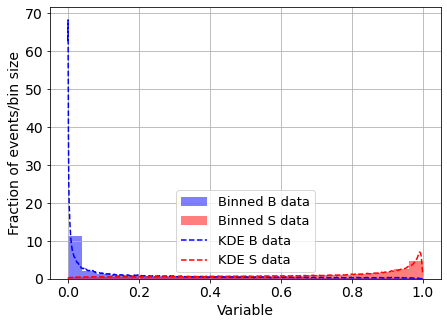

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0031053121543406503


In [504]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs

# outputs:
# 1st -> background PDF
# 2nd -> signal PDF
# 3rd -> (normalization factor of the background PDF)**-1
# 4th -> (normalization factor of the signal PDF)**-1
# 5th -> background bandwidth
# 6th -> signal bandwidth
pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] == (BPS_trained[0] + 1))[0]]

kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                        50000, # Numero de datos para fitear
                                                                                        np.logspace(-4.0, 0.05, 20), 
                                                                                        set_kernel='epanechnikov')

(60000, 4)


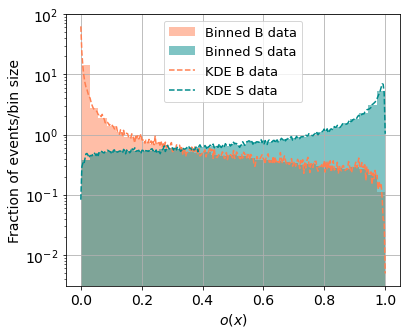

In [505]:
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

# points
s_vals = np.linspace(min_val,max_val,300)

# evaluate the PDFs for each value of s
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )

# normalize
dens_bkg = dens_bkg / norm_factor_SM
dens_sig = dens_sig / norm_factor_NP

plt.figure(figsize=(6,5))

plt.hist(pred_XG_SM, 35, range=[min_val,max_val], density=True, color='coral',alpha=0.5, linewidth=2, label=r'Binned B data');
plt.hist(pred_XG_NP, 35, range=[min_val,max_val], density=True, color='darkcyan',alpha=0.5, linewidth=2, label=r'Binned S data');

plt.plot(s_vals, dens_bkg, color='coral',label=r'KDE B data',linestyle='dashed');
plt.plot(s_vals, dens_sig, color='darkcyan',label=r'KDE S data',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xlabel("$o(x)$",fontsize=14)
plt.ylabel("Fraction of events/bin size",fontsize=14)
plt.grid()
plt.legend(loc='upper center',fontsize=13)

print(photon_SM.shape)
plt.savefig('../graph/KDE_fit_ALLBPs_MET200_new.pdf', bbox_inches='tight')

In [506]:
print('This may take a while...')

pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
print('1 done')
pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
print('2 done')

# Normalize
pB_B_data = pB_B_data / norm_factor_SM
pS_B_data = pS_B_data / norm_factor_NP

This may take a while...
1 done
2 done


In [507]:
print(np.min(pB_B_data))
pB_B_data[np.where(pB_B_data == 0 )[0]] = np.min(pB_B_data[np.where(pB_B_data > 0 )[0]])
pS_B_data[np.where(pS_B_data == 0 )[0]] = np.min(pS_B_data[np.where(pS_B_data > 0 )[0]])
print(np.min(pB_B_data))

0.010867645212509503
0.010867645212509503


0:10000
3 done
4 done
0.004977347805966106
0.004977347805966106
B_expected:  26060
S_expected:  81

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


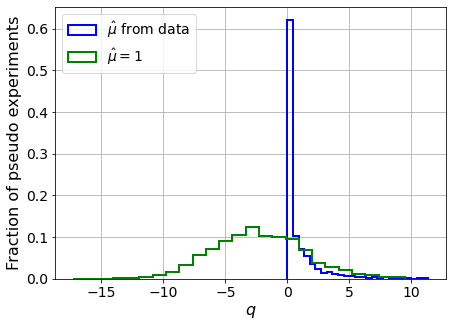

BP1
muhat mean:  0.27709999999999996
Z_MLL:  0.33748458676100623
std Z_MLL:  2.287138842564051
Z_MLL mu=1:  1.5595012179696686
std Z_MLL mu=1:  1.1947260405644056

--------

1:10000
3 done
4 done
0.005761103667751231
0.005761103667751231
B_expected:  26060
S_expected:  205

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


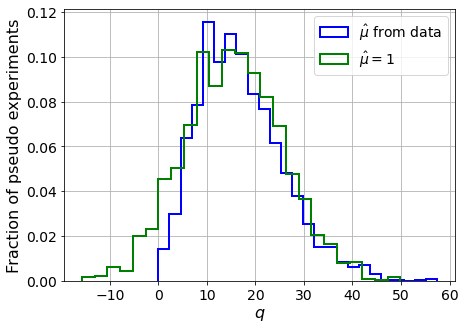

BP2
muhat mean:  0.8525250000000001
Z_MLL:  3.989169982036734
std Z_MLL:  1.0942270165304495
Z_MLL mu=1:  3.9307974439090394
std Z_MLL mu=1:  1.2764946739379242

--------

2:10000
3 done
4 done
0.005169522392145157
0.005169522392145157
B_expected:  26060
S_expected:  343

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


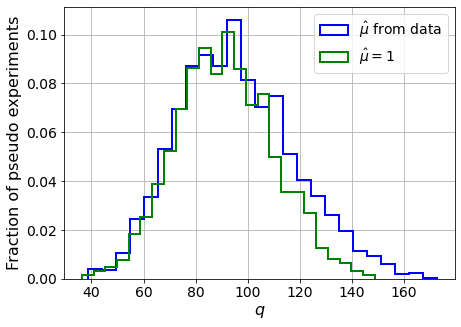

BP3
muhat mean:  1.3119250000000002
Z_MLL:  9.695756573615606
std Z_MLL:  1.1515419394247977
Z_MLL mu=1:  9.52901321172544
std Z_MLL mu=1:  0.9767788785101245

--------

3:10000
3 done
4 done
0.006473259326182823
0.006473259326182823
B_expected:  26060
S_expected:  49

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


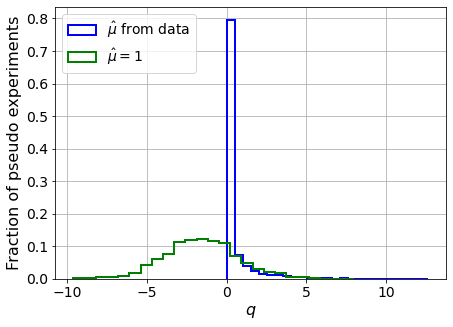

BP4
muhat mean:  0.24725
Z_MLL:  0.0
std Z_MLL:  inf
Z_MLL mu=1:  1.2680686247806832
std Z_MLL mu=1:  0.9189833071351763

--------

4:10000
3 done


/home/martinrios/martin/trabajos/susyatLHC/codes/AUX_MLL_BL.py:1097: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std = np.std(q_muhat_MLL) / (2.*Z_MLL)


4 done
0.005623654190622025
0.005623654190622025
B_expected:  26060
S_expected:  112

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


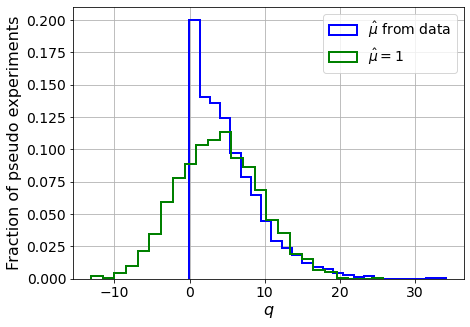

BP5
muhat mean:  0.7757000000000001
Z_MLL:  2.071471410216421
std Z_MLL:  1.0957177472674275
Z_MLL mu=1:  1.9780418659855916
std Z_MLL mu=1:  1.3919420264215248

--------

5:10000
3 done
4 done
0.004873046837177824
0.004873046837177824
B_expected:  26060
S_expected:  179

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


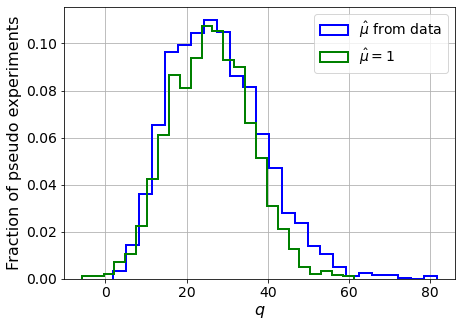

BP6
muhat mean:  1.233
Z_MLL:  5.14215037028905
std Z_MLL:  1.1095869308978008
Z_MLL mu=1:  5.085361028122393
std Z_MLL mu=1:  0.9573405886113874

--------

6:10000
3 done
4 done
0.005108503077483555
0.005108503077483555
B_expected:  26060
S_expected:  31

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


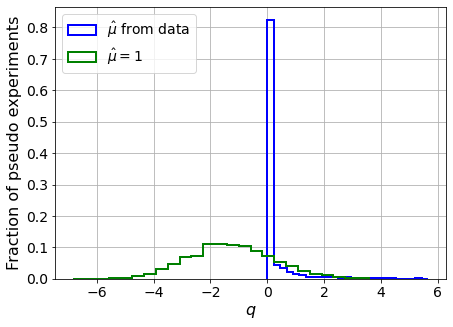

BP7
muhat mean:  0.199875
Z_MLL:  0.0
std Z_MLL:  inf
Z_MLL mu=1:  1.1397842363061215
std Z_MLL mu=1:  0.645053227150826

--------

7:10000
3 done


/home/martinrios/martin/trabajos/susyatLHC/codes/AUX_MLL_BL.py:1097: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std = np.std(q_muhat_MLL) / (2.*Z_MLL)


4 done
0.004911170068433691
0.004911170068433691
B_expected:  26060
S_expected:  64

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


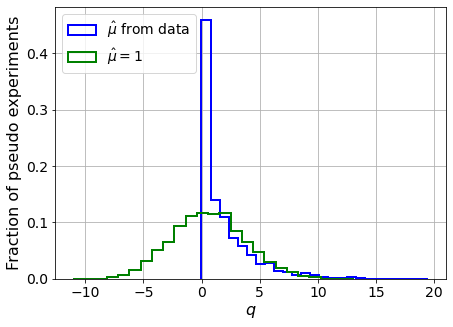

BP8
muhat mean:  0.6576500000000001
Z_MLL:  0.9874739729592373
std Z_MLL:  1.232992541962718
Z_MLL mu=1:  0.7671914301851549
std Z_MLL mu=1:  2.0846738015383175

--------

8:10000
3 done
4 done
0.00510566087542637
0.00510566087542637
B_expected:  26060
S_expected:  97

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


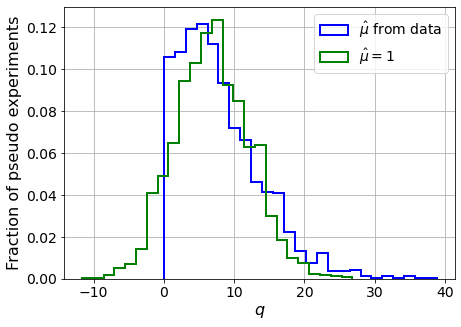

BP9
muhat mean:  1.1065
Z_MLL:  2.616756215211273
std Z_MLL:  1.1246544937210186
Z_MLL mu=1:  2.610017648190228
std Z_MLL mu=1:  1.0175101855691835

--------

9:10000
3 done
4 done
0.004614263607816423
0.004614263607816423
B_expected:  26060
S_expected:  20

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


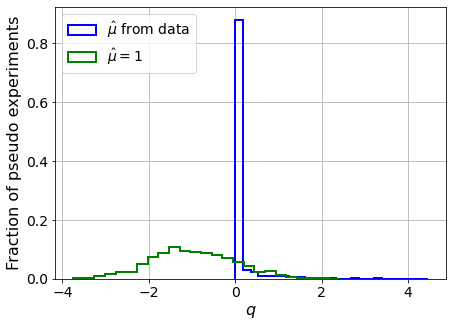

BP10
muhat mean:  0.158675
Z_MLL:  0.0
std Z_MLL:  inf
Z_MLL mu=1:  1.0098048923895266
std Z_MLL mu=1:  0.47953842644541983

--------

10:10000


/home/martinrios/martin/trabajos/susyatLHC/codes/AUX_MLL_BL.py:1097: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std = np.std(q_muhat_MLL) / (2.*Z_MLL)


3 done
4 done
0.004758061554106013
0.004758061554106013
B_expected:  26060
S_expected:  38

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


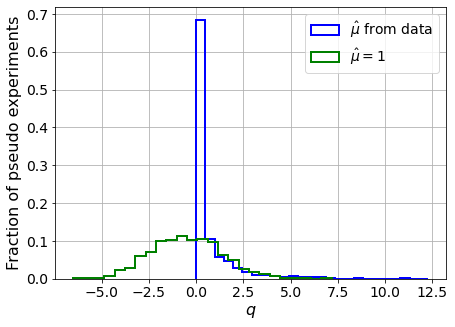

BP11
muhat mean:  0.474575
Z_MLL:  0.19070515358419
std Z_MLL:  3.468582913463761
Z_MLL mu=1:  0.7356683980768101
std Z_MLL mu=1:  1.2886676973365085

--------

11:10000
3 done
4 done
0.004898195315385129
0.004898195315385129
B_expected:  26060
S_expected:  56

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


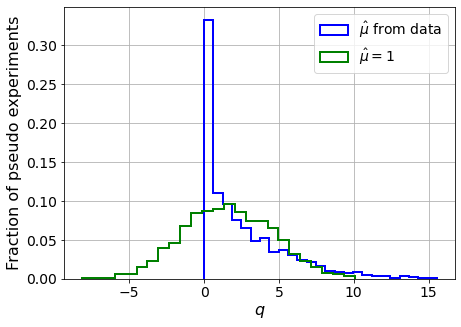

BP12
muhat mean:  0.9092
Z_MLL:  1.2686558353104895
std Z_MLL:  1.136578041718486
Z_MLL mu=1:  1.2537852173324864
std Z_MLL mu=1:  1.185808435840294

--------

12:10000
3 done
4 done
0.005311864495314045
0.005311864495314045
B_expected:  26060
S_expected:  12

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


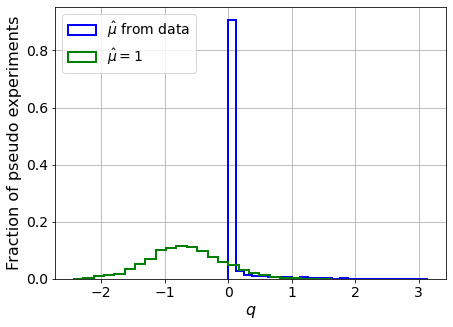

BP13
muhat mean:  0.12835000000000002
Z_MLL:  0.0
std Z_MLL:  inf
Z_MLL mu=1:  0.8299482039357012
std Z_MLL mu=1:  0.3499468294029866

--------

13:10000
3 done


/home/martinrios/martin/trabajos/susyatLHC/codes/AUX_MLL_BL.py:1097: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std = np.std(q_muhat_MLL) / (2.*Z_MLL)


4 done
0.005082297291265321
0.005082297291265321
B_expected:  26060
S_expected:  22

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


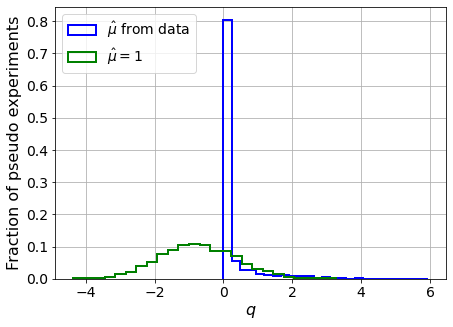

BP14
muhat mean:  0.31825
Z_MLL:  0.0
std Z_MLL:  inf
Z_MLL mu=1:  0.873005388601893
std Z_MLL mu=1:  0.6376651704719684

--------

14:10000
3 done


/home/martinrios/martin/trabajos/susyatLHC/codes/AUX_MLL_BL.py:1097: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std = np.std(q_muhat_MLL) / (2.*Z_MLL)


4 done
0.004862362500017587
0.004862362500017587
B_expected:  26060
S_expected:  32

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


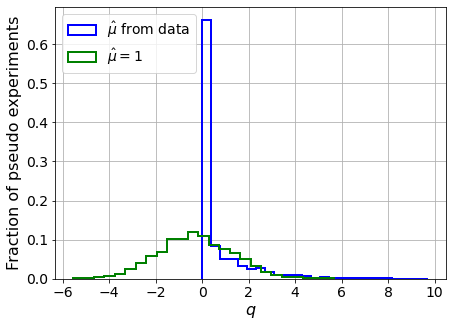

BP15
muhat mean:  0.5639500000000001
Z_MLL:  0.23326179217998533
std Z_MLL:  2.6656388462689815
Z_MLL mu=1:  0.5528081595937018
std Z_MLL mu=1:  1.470786128572336

--------



In [508]:
D_or_E = "discovery"

Z_MLL_BPs = np.ones(15) * (-99)
Z_MLL_std_BPs = np.ones(15) * (-99)
muhat_MLL = np.ones(15) * (-99)
for bp in BPS_analyzed:
    pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] == (bp+1))[0]]
    BP_indices = np.random.choice(np.arange(len(pred_XG_NP)), size = 10000, replace = False)
    pred_XG_NP = pred_XG_NP[BP_indices]

    print(str(bp) + ':' + str(len(pred_XG_NP)))
    # FOR DISCOVERY:
    # we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

    pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
    print('3 done')
    pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
    print('4 done')

    # Normalize
    pB_S_data = pB_S_data / norm_factor_SM
    pS_S_data = pS_S_data / norm_factor_NP
    
    print(np.min(pB_S_data))
    pB_S_data[np.where(pB_S_data == 0 )[0]] = np.min(pB_S_data[np.where(pB_S_data > 0 )[0]])
    pS_S_data[np.where(pS_S_data == 0 )[0]] = np.min(pS_S_data[np.where(pS_S_data > 0 )[0]])
    print(np.min(pB_S_data))
    
    print('B_expected: ', int(B_expected))
    print('S_expected: ', int(S_expected[bp]))
    print('')

    Z_MLL = MLL_test_fast(D_or_E, pB_B_data, pS_B_data, pB_S_data, 
                          pS_S_data, B_expected, int(S_expected[bp]), num_pseudo = 2000)
    #Z_MLL = MLL_test_fsolve(D_or_E, pB_B_data, pS_B_data, pB_S_data, pS_S_data, 
    #                        B_expected, int(S_expected[bp]), num_pseudo = 2000)

    Z_MLL_BPs[bp] = Z_MLL[0]
    Z_MLL_std_BPs[bp] = Z_MLL[1]
    muhat_MLL[bp] = Z_MLL[2]
    
    print('BP' + str(bp+1))
    print('muhat mean: ', Z_MLL[2])
    print('Z_MLL: ', Z_MLL[0])
    print('std Z_MLL: ', Z_MLL[1])
    print('Z_MLL mu=1: ', Z_MLL[3])
    print('std Z_MLL mu=1: ', Z_MLL[4])
    print('')
    print('--------\n')

In [509]:
Z_BL_loops.append( Z_BL_BPs )
Z_BL_std_loops.append( Z_BL_std_BPs )
muhat_BL_loops.append( muhat_BL )

Z_MLL_loops.append( Z_MLL_BPs )
Z_MLL_std_loops.append( Z_MLL_std_BPs )
muhat_MLL_loops.append( muhat_MLL )

In [510]:
Z_BL_loops

[array([ 1.54510007,  4.6617903 , 10.04804473,  1.08554459,  2.84585512,
         5.50405332,  0.74473692,  1.78090032,  3.15462591,  0.53484744,
         1.18533744,  1.89027926,  0.34060097,  0.68952131,  1.1135407 ]),
 array([1.52585979, 4.53059474, 9.67051551, 1.09318239, 2.79622286,
        5.36197377, 0.74459287, 1.79690001, 3.07985406, 0.51937029,
        1.18220344, 1.82724349, 0.34053186, 0.71218362, 1.12546778]),
 array([1.5357303 , 4.56515137, 9.76279572, 1.05773039, 2.82114068,
        5.42340169, 0.72083071, 1.80081868, 3.07847141, 0.54041589,
        1.15996604, 1.87610357, 0.31644828, 0.68938329, 1.12970679]),
 array([1.5752623 , 4.72661571, 9.99095235, 1.05934786, 2.94276851,
        5.58759533, 0.77446495, 1.87213516, 3.21028441, 0.55412082,
        1.23219162, 1.95103351, 0.37310583, 0.74280688, 1.17166127]),
 array([1.53137516, 4.60226009, 9.69707994, 1.05618001, 2.8036203 ,
        5.40704458, 0.74384133, 1.76573751, 3.10999761, 0.54019539,
        1.16925411, 1.875

In [511]:
Z_MLL_loops

[array([ 1.86306558,  6.31102988, 12.03605784,  1.23858369,  4.09875261,
         8.06491533,  0.70129333,  2.86901809,  4.99620008,  0.34949172,
         1.86201525,  3.50808937,  0.09933664,  1.00656169,  2.07621459]),
 array([ 1.83722795,  5.68233476, 14.34249892,  1.02070528,  4.12477074,
         9.25740443,  0.55654349,  2.78951349,  6.39303421,  0.26092178,
         1.75537959,  3.76935988,  0.        ,  1.23915767,  2.687211  ]),
 array([ 1.24069046,  4.8672368 , 11.4886681 ,  0.56635292,  3.7378306 ,
         7.20102459,  0.29909986,  2.24517955,  3.91863377,  0.        ,
         1.29991379,  2.72538674,  0.        ,  0.39203309,  1.82532103]),
 array([ 0.51891616,  4.11146089, 10.09521361,  0.03686853,  2.29813156,
         5.39441091,  0.        ,  1.16378473,  2.8829857 ,  0.        ,
         0.36744848,  1.30706536,  0.        ,  0.        ,  0.36503816]),
 array([ 1.36711824,  6.04600588, 12.63190766,  0.8594051 ,  4.11458901,
         8.24394779,  0.63640839,  3.151664

In [ ]:
#Z_MLL_loops = [np.array([ 1.20491363,  5.08755597, 11.11844108,  0.85819953,  3.26846852,
#         6.38480358,  0.40324626,  1.90463207,  3.78551188,  0.10997325,
#         1.08401958,  2.16554968,  0.        ,  0.4390967 ,  1.0747124 ]),
#               np.array([0.2237681 , 3.7204386 , 9.74196831, 0.        , 1.90189066,
#        5.33708079, 0.        , 0.84982888, 2.60592166, 0.        ,
#        0.1276471 , 1.09919672, 0.        , 0.        , 0.18346223]),
#               np.array([ 1.23463048,  4.87506599, 10.93821405,  0.7804577 ,  3.05017043,
#         6.1169838 ,  0.29798708,  1.79800699,  3.30301956,  0.0454265 ,
#         0.96384899,  2.06365563,  0.        ,  0.34553805,  1.03774563]),
#               np.array([0.        , 3.67640709, 9.23837109, 0.        , 1.82184869,
#        4.85475666, 0.        , 0.73753921, 2.32591743, 0.        ,
#        0.        , 0.96805473, 0.        , 0.        , 0.        ])]

In [ ]:
#Z_BL_loops = [ np.array([1.54696354, 4.64222181, 9.87110223, 1.06446858, 2.8620769 ,
#        5.49544431, 0.74824352, 1.72684315, 3.16373762, 0.54889515,
#        1.13150535, 1.87048138, 0.37844522, 0.71297778, 1.14581066]),
#               np.array([1.48891062, 4.66199591, 9.90013348, 1.06371307, 2.83885026,
#        5.46402479, 0.7881112 , 1.80584544, 3.15987558, 0.49669537,
#        1.14979865, 1.8693404 , 0.3465873 , 0.71470354, 1.13072254]),
#               np.array([1.54429504, 4.64997402, 9.90769956, 1.07549076, 2.83223523,
#        5.50062388, 0.76493381, 1.81447085, 3.17120743, 0.54820861,
#        1.18207902, 1.93750524, 0.33998942, 0.70766092, 1.18228295]),
#               np.array([1.52445992, 4.65865358, 9.86025056, 1.06881479, 2.87252629,
#        5.57328726, 0.78669594, 1.81715464, 3.15900596, 0.54990753,
#        1.17709469, 1.93204733, 0.36536989, 0.74965081, 1.17356042])]

In [512]:
Z_BL_loops_ar = np.asarray(Z_BL_loops)
Z_BL_std_loops_ar = np.asarray(Z_BL_std_loops)
muhat_BL_loops_ar = np.asarray(muhat_BL_loops)

Z_MLL_loops_ar = np.asarray(Z_MLL_loops)
Z_MLL_std_loops_ar = np.asarray(Z_MLL_std_loops)
muhat_MLL_loops_ar = np.asarray(muhat_MLL_loops)

In [513]:
np.save('../data/temp_Z_BL_loops_ar_MET200.npy', Z_BL_loops_ar)
np.save('../data/temp_Z_BL_std_loops_ar_MET200.npy', Z_BL_std_loops_ar)
np.save('../data/temp_muhat_BL_loops_ar_MET200.npy', muhat_BL_loops_ar)
np.save('../data/temp_Z_MLL_loops_ar_MET200.npy', Z_MLL_loops_ar)
np.save('../data/temp_Z_MLL_std_loops_ar_MET200.npy', Z_MLL_std_loops_ar)
np.save('../data/temp_muhat_MLL_loops_ar_MET200.npy', muhat_MLL_loops_ar)

In [594]:
Z_BL_loops_ar[:,0]

array([1.54510007, 1.52585979, 1.5357303 , 1.5752623 , 1.53137516,
       1.61921238, 1.5634656 , 1.53306735, 1.51356435, 1.5340558 ,
       1.54213035, 1.50081876])

In [592]:
Z_MLL_loops_ar[:,0]

array([1.86306558, 1.83722795, 1.24069046, 0.51891616, 1.36711824,
       0.14920881, 0.22027041, 1.67136863, 1.10436483, 0.52764477,
       0.08907071, 0.33748459])

In [593]:
Z_MLL_std_loops_ar[:,0]

array([2.46956084, 2.02518295, 1.31342284, 1.78059286, 1.64566965,
       4.41326557, 3.47950191, 1.17298217, 1.27031448, 1.81257942,
       7.25545135, 2.28713884])

In [583]:
from scipy.stats import sigmaclip
fact = 2
aux = np.where(Z_MLL_loops_ar[:,10] != 0)[0]
c, low, upp = sigmaclip(Z_MLL_std_loops_ar[aux,10], fact, fact)

In [584]:
c

array([1.17520048, 1.25679455, 1.98500729, 2.06187479, 1.59593479,
       1.8048245 , 1.1323203 , 1.64799841])

In [590]:
for i in range(15):
    aux = np.where(Z_MLL_loops_ar[:,i] != 0)[0]
    print('BP' + str(i+1) + ': Z_BL: ' + str(np.mean(Z_BL_loops_ar[aux,i])) + ' +/- ' + str(np.std(Z_BL_loops_ar[aux,i])) + ' +/- ' + str(np.mean(Z_BL_std_loops_ar[aux,i])))
    #print('BP' + str(i+1) + ': Z_BL: ' + str(np.mean(Z_BL_loops_ar, axis = 0)[i]) + ' +/- ' + str(np.std(Z_BL_loops_ar, axis = 0)[i]) + ' +/- ' + str(np.mean(Z_BL_std_loops_ar, axis = 0)[i]))

BP1: Z_BL: 1.543303515928688 +/- 0.029690385950699123 +/- 0.813232129322083
BP2: Z_BL: 4.636143142055721 +/- 0.07543533242064371 +/- 0.8243316189766013
BP3: Z_BL: 9.821266195260561 +/- 0.15252033883292523 +/- 0.9075899534151676
BP4: Z_BL: 1.0780536227556077 +/- 0.016605021618710285 +/- 0.8285199079498168
BP5: Z_BL: 2.8467760980978754 +/- 0.04667214096384469 +/- 0.8082497194389185
BP6: Z_BL: 5.449089729138483 +/- 0.0861867381373809 +/- 0.8385386237132356
BP7: Z_BL: 0.7525039542031003 +/- 0.021574678234087423 +/- 0.8554362474108158
BP8: Z_BL: 1.804335469462026 +/- 0.029589888243101947 +/- 0.808407586829324
BP9: Z_BL: 3.137921187768575 +/- 0.04668565394659014 +/- 0.8068986009479678
BP10: Z_BL: 0.5392112766044683 +/- 0.012550393924260413 +/- 0.8676474460999156
BP11: Z_BL: 1.1689077090628044 +/- 0.03198561747393795 +/- 0.7956149587869915
BP12: Z_BL: 1.8854095153528314 +/- 0.042974258125024874 +/- 0.8040950547775623
BP13: Z_BL: 0.34060097 +/- 0.0 +/- 0.87143215
BP14: Z_BL: 0.7206917267126877

In [587]:
for i in range(15):
    aux = np.where(Z_MLL_loops_ar[:,i] != 0)[0]
    print('BP' + str(i+1) + ': Z_MLL: ' + str(np.mean(Z_MLL_loops_ar[aux,i])) + ' +/- ' + str(np.std(Z_MLL_loops_ar[aux,i])) + ' +/- ' + str(np.mean(sigmaclip(Z_MLL_std_loops_ar[aux,i], 2, 2)[0])))
    #print('BP' + str(i+1) + ': Z_MLL: ' + str(np.mean(Z_MLL_loops_ar[aux,i])) + ' +/- ' + str(np.std(Z_MLL_loops_ar[aux,i])) + ' +/- ' + str(np.mean(Z_MLL_std_loops_ar[aux,i])))
    #print('BP' + str(i+1) + ': Z_MLL: ' + str(np.mean(Z_MLL_loops_ar, axis = 0)[i]) + ' +/- ' + str(np.std(Z_MLL_loops_ar, axis = 0)[i]) + ' +/- ' + str(np.mean(Z_MLL_std_loops_ar, axis = 0)[i]))

BP1: Z_MLL: 0.910535927497655 +/- 0.6493090182161186 +/- 1.7530493403630638
BP2: Z_MLL: 4.751240549793343 +/- 0.8994193451963204 +/- 1.208587476317755
BP3: Z_MLL: 10.948270354559737 +/- 1.5375008023866479 +/- 1.214649754934445
BP4: Z_MLL: 0.7383828098181081 +/- 0.418083468894791 +/- 1.7881878079640015
BP5: Z_MLL: 2.9710409844569052 +/- 0.9203487985238075 +/- 1.1166605612593279
BP6: Z_MLL: 6.509603968774279 +/- 1.4509697441777252 +/- 1.2416607990858872
BP7: Z_MLL: 0.5338459237564821 +/- 0.17122552060220222 +/- 3.957859283184622
BP8: Z_MLL: 1.794031993281182 +/- 0.8660728856833473 +/- 1.3254079697232994
BP9: Z_MLL: 3.805497722405704 +/- 1.3099887905377086 +/- 1.2011289248141126
BP10: Z_MLL: 0.2302068172160135 +/- 0.10890910150623788 +/- 5.994559922856919
BP11: Z_MLL: 1.0926213856540146 +/- 0.8489483059496702 +/- 1.5824943874475994
BP12: Z_MLL: 2.1824026206471827 +/- 1.0242213716495312 +/- 1.31617967908535
BP13: Z_MLL: 0.09933664 +/- 0.0 +/- 7.55757447
BP14: Z_MLL: 0.8525416792074528 +/- 

## loop varying ML

In [ ]:
lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       'SM=0 - NP=1']

In [ ]:
B_expected

In [ ]:
nloops = 10
Z_MLL        = np.zeros((15, nloops))
Z_MLL_std    = np.zeros((15, nloops))
Z_MLL_mu     = np.zeros((15, nloops))
Z_MLL_std_mu = np.zeros((15, nloops))

auc_total   = []
auc_wgamma  = []
auc_wjets   = []
auc_ttgamma = []

BPS_analyzed = np.arange(15)

np.random.seed(28890)

for iloop in range(nloops):
    
    print(iloop)
    nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
    nobs_bp = round(nobs / len(BPS_analyzed))
    
    SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

    df = pd.DataFrame()

    mask_list = []
    for bp in BPS_analyzed:
        BP_indices = np.random.choice(np.arange(len(photon_NP[bp])), size = nobs_bp, replace = False)
        mask = np.ones(len(photon_NP[bp]), dtype=bool)
        mask[BP_indices] = False
        mask_list.append( mask )
        if bp == 0:

            df[lst[0]] = np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][BP_indices,0]])
            df[lst[1]] = np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][BP_indices,1]])
            df[lst[2]] = np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][BP_indices,2]])
            df[lst[3]] = np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][BP_indices,3]])

            df[lst[4]] = np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][BP_indices,0]])
            df[lst[5]] = np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][BP_indices,1]])
            df[lst[6]] = np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][BP_indices,2]])

            df[lst[7]] = np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][BP_indices,0]])
            df[lst[8]] = np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][BP_indices,1]])
            df[lst[9]] = np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][BP_indices,2]])
            df[lst[10]] = np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][BP_indices,3]])
            df[lst[11]] = np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][BP_indices,4]])

            df[lst[12]] = np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][BP_indices,0]])
            df[lst[13]] = np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][BP_indices,2]])

            df[lst[14]] = np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][BP_indices,0]])
            df[lst[15]] = np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][BP_indices,1]])
            df[lst[16]] = np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][BP_indices,2]])

            df[lst[17]] = np.concatenate([ST_SM[SM_indices], ST_NP[bp][BP_indices]])
            df[lst[18]] = np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][BP_indices]])

            df[lst[19]] = np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][BP_indices]])
            df[lst[20]] = np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][BP_indices]])
            df[lst[21]] = np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][BP_indices]])


            df['bkg_flag'] = np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][BP_indices]))) )

            df[lst[22]] = np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][BP_indices]))])

            df['bp_flag'] = np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][BP_indices])) * (bp+1) ])
        else:
            df_aux = pd.DataFrame()

            df_aux[lst[0]] = photon_NP[bp][BP_indices,0] 
            df_aux[lst[1]] = photon_NP[bp][BP_indices,1] 
            df_aux[lst[2]] = photon_NP[bp][BP_indices,2] 
            df_aux[lst[3]] = photon_NP[bp][BP_indices,3] 

            df_aux[lst[4]] = jet_NP[bp][BP_indices,0] 
            df_aux[lst[5]] = jet_NP[bp][BP_indices,1] 
            df_aux[lst[6]] = jet_NP[bp][BP_indices,2] 

            df_aux[lst[7]] = lepton_NP[bp][BP_indices,0] 
            df_aux[lst[8]] = lepton_NP[bp][BP_indices,1] 
            df_aux[lst[9]] = lepton_NP[bp][BP_indices,2] 
            df_aux[lst[10]] = lepton_NP[bp][BP_indices,3] 
            df_aux[lst[11]] = lepton_NP[bp][BP_indices,4] 

            df_aux[lst[12]] = MET_NP[bp][BP_indices,0] 
            df_aux[lst[13]] = MET_NP[bp][BP_indices,2] 

            df_aux[lst[14]] = hadinfo_NP[bp][BP_indices,0] 
            df_aux[lst[15]] = hadinfo_NP[bp][BP_indices,1] 
            df_aux[lst[16]] = hadinfo_NP[bp][BP_indices,2] 

            df_aux[lst[17]] = ST_NP[bp][BP_indices] 
            df_aux[lst[18]] = MET_sig_NP[bp][BP_indices] 

            df_aux[lst[19]] = mT_photon_NP[bp][BP_indices] 
            df_aux[lst[20]] = mT_jet_NP[bp][BP_indices] 
            df_aux[lst[21]] = mT_lepton_NP[bp][BP_indices] 


            df_aux['bkg_flag'] = np.zeros(len(photon_NP[bp][BP_indices]))

            df_aux[lst[22]] = np.ones(len(photon_NP[bp][BP_indices]))
            df_aux['bp_flag'] = np.ones(len(photon_NP[bp][BP_indices])) * (bp+1) 

            df = pd.concat((df, df_aux))
    df_array = np.asarray(df)
    
    
    SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

    df_test = pd.DataFrame()

    for bp in BPS_analyzed:
        mask = mask_list[bp]
        mask[np.random.choice(np.arange(len(mask)), (len(mask) - 15_000), replace = False)] = False # Set to false everything but 15000
        
        if bp == 0:

            df_test[lst[0]] = np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][mask,0]])
            df_test[lst[1]] = np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][mask,1]])
            df_test[lst[2]] = np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][mask,2]])
            df_test[lst[3]] = np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][mask,3]])

            df_test[lst[4]] = np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][mask,0]])
            df_test[lst[5]] = np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][mask,1]])
            df_test[lst[6]] = np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][mask,2]])

            df_test[lst[7]] = np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][mask,0]])
            df_test[lst[8]] = np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][mask,1]])
            df_test[lst[9]] = np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][mask,2]])
            df_test[lst[10]] = np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][mask,3]])
            df_test[lst[11]] = np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][mask,4]])

            df_test[lst[12]] = np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][mask,0]])
            df_test[lst[13]] = np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][mask,2]])

            df_test[lst[14]] = np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][mask,0]])
            df_test[lst[15]] = np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][mask,1]])
            df_test[lst[16]] = np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][mask,2]])

            df_test[lst[17]] = np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][mask]])
            df_test[lst[18]] = np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][mask]])

            df_test[lst[19]] = np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][mask]])
            df_test[lst[20]] = np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][mask]])
            df_test[lst[21]] = np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][mask]])


            df_test['bkg_flag_pool'] = np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][mask]))) )

            df_test[lst[22]] = np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][mask]))])

            df_test['bp_flag'] = np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][mask])) * (bp+1) ])

        else:
            df_aux = pd.DataFrame()

            df_aux[lst[0]] = photon_NP[bp][mask,0] 
            df_aux[lst[1]] = photon_NP[bp][mask,1] 
            df_aux[lst[2]] = photon_NP[bp][mask,2] 
            df_aux[lst[3]] = photon_NP[bp][mask,3] 

            df_aux[lst[4]] = jet_NP[bp][mask,0] 
            df_aux[lst[5]] = jet_NP[bp][mask,1] 
            df_aux[lst[6]] = jet_NP[bp][mask,2] 

            df_aux[lst[7]] = lepton_NP[bp][mask,0] 
            df_aux[lst[8]] = lepton_NP[bp][mask,1] 
            df_aux[lst[9]] = lepton_NP[bp][mask,2] 
            df_aux[lst[10]] = lepton_NP[bp][mask,3] 
            df_aux[lst[11]] = lepton_NP[bp][mask,4] 

            df_aux[lst[12]] = MET_NP[bp][mask,0] 
            df_aux[lst[13]] = MET_NP[bp][mask,2] 

            df_aux[lst[14]] = hadinfo_NP[bp][mask,0] 
            df_aux[lst[15]] = hadinfo_NP[bp][mask,1] 
            df_aux[lst[16]] = hadinfo_NP[bp][mask,2] 

            df_aux[lst[17]] = ST_NP[bp][mask] 
            df_aux[lst[18]] = MET_sig_NP[bp][mask] 

            df_aux[lst[19]] = mT_photon_NP[bp][mask] 
            df_aux[lst[20]] = mT_jet_NP[bp][mask] 
            df_aux[lst[21]] = mT_lepton_NP[bp][mask] 


            df_aux['bkg_flag_pool'] = np.zeros(len(photon_NP[bp][mask]))

            df_aux[lst[22]] = np.ones(len(photon_NP[bp][mask]))

            df_aux['bp_flag'] = np.ones(len(photon_NP[bp][mask])) * (bp+1)

            df_test = pd.concat((df_test, df_aux))
    df_test_array = np.asarray(df_test)
    
    nobs = len(df_array)

    train_size = int(0.80 * nobs)
    val_size   = nobs - train_size #%- test_size 

    random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

    train_indices = random_indices[:train_size]
    val_indices   = random_indices[train_size:]    
    
    X_train        = df_array[train_indices, :22]
    bkg_flag_train = df_array[train_indices, 22]
    y_mon_train    = df_array[train_indices, -2]

    X_test        = df_test_array[:, :22]
    bkg_flag_test = df_test_array[:, 22]
    y_mon_test    = df_test_array[:, -2]

    X_val        = df_array[val_indices, :22]
    bkg_flag_val = df_array[val_indices, 22]
    y_mon_val    = df_array[val_indices, -2]
    
    # to normalize
    x_scaler = preprocessing.MinMaxScaler()
    x_scaler = x_scaler.fit(X_train)

    X_mon_train = x_scaler.transform(X_train)
    X_mon_test  = x_scaler.transform(X_test)
    X_mon_val   = x_scaler.transform(X_val)
    
    
    # CLASSIFIER
    classifier = XGBClassifier(
        n_estimators  = 500,
        learning_rate = 0.1,
        reg_lambda    = 0.0, reg_alpha = 0.0,
        early_stopping_rounds = 50,#early stopping
        eval_metric = 'logloss',
        gamma = 0.0, objective = 'binary:logistic',
        max_depth = 5)

    # FIT
    classifier.fit(X_mon_train, y_mon_train, 
                   eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
                   verbose  = False)

    # PREDICTIONS
    y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

    pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
    pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]
    
    
    # Let's estimate the ROC Curve
    nvals = 50
    tpr_total   = np.zeros(nvals) 
    fpr_total   = np.zeros(nvals) 
    tpr_ttgamma = np.zeros(nvals) 
    fpr_ttgamma = np.zeros(nvals) 
    tpr_wgamma  = np.zeros(nvals) 
    fpr_wgamma  = np.zeros(nvals) 
    tpr_wjets   = np.zeros(nvals) 
    fpr_wjets   = np.zeros(nvals) 

    for ith, th in enumerate(np.linspace(0,1, nvals)):
        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_total[ith] = len(tp) / (len(tp) + len(fn))
        fpr_total[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_ttgamma.append( auc(fpr_ttgamma, tpr_ttgamma) )
    auc_wjets.append( auc(fpr_wjets, tpr_wjets) )
    auc_wgamma.append( auc(fpr_wgamma, tpr_wgamma) )
    auc_total.append( auc(fpr_total, tpr_total) )
    
    
    print('AUC:' + str(auc_total[iloop]))
    
    NP_indices = np.random.choice(np.arange(len(pred_XG_NP)), size = 50_000, replace = False)
    SM_indices = np.random.choice(np.arange(len(pred_XG_SM)), size = 50_000, replace = False)
    
    kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM[SM_indices], pred_XG_NP[NP_indices], 
                                                                                            50000, # Numero de datos para fitear
                                                                                            np.logspace(-4.0, 0.05, 20), 
                                                                                            set_kernel='epanechnikov')
    mask = np.ones(len(pred_XG_SM), dtype=bool)
    mask[SM_indices] = False
    pred_XG_SM = pred_XG_SM[mask]
    print('This may take a while...')

    pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
    print('1 done')
    pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
    print('2 done')

    # Normalize
    pB_B_data = pB_B_data / norm_factor_SM
    pS_B_data = pS_B_data / norm_factor_NP

    # indeces (to later build a random pseudo experiment)
    indices_B = [i for i in range(len(pS_B_data))]
    # loop over the number of pseudo experiments
    #np.random.seed(91218)

    for bp in BPS_analyzed:
        pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] == (bp+1))[0]]
        pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
        print('3 done')
        pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
        print('4 done')

        # Normalize
        pB_S_data = pB_S_data / norm_factor_SM
        pS_S_data = pS_S_data / norm_factor_NP
        indices_S = [i for i in range(len(pS_S_data))]
        
        muhat_selected_MLL_list = []
        q_muhat_MLL = []
        q_muhat_MLL_mu = []
        for its in tqdm(range(10)):

            # this pseudo-exp has B_rand number of B events
            B_rand = np.random.poisson(int(B_expected))

            ran_ind = np.random.choice(indices_B, B_rand)

            pB_B_data_shuf = []
            pS_B_data_shuf = []

            # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
            for i in ran_ind:
                pB_B_data_shuf.append(pB_B_data[i])
                pS_B_data_shuf.append(pS_B_data[i])

            pB_B_data_shuf  = np.array(pB_B_data_shuf)
            pS_B_data_shuf  = np.array(pS_B_data_shuf)

            # this pseudo-exp has S_rand number of S events
            S_rand = np.random.poisson(int(S_expected[bp]))

            ran_ind = np.random.choice(indices_S, S_rand)

            pB_S_data_shuf = []
            pS_S_data_shuf = []

            # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
            for i in ran_ind:
                pB_S_data_shuf.append(pB_S_data[i])
                pS_S_data_shuf.append(pS_S_data[i])

            pB_S_data_shuf  = np.array(pB_S_data_shuf)
            pS_S_data_shuf  = np.array(pS_S_data_shuf)

            # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
            prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])
            prob_x_given_B[np.where(prob_x_given_B <= 0)[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0)[0]])
            # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
            prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

            # approximation: mu_hat=1 (discovery)
            q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



            # ESTIMATE mu_hat for this particular ensemble (implicit equation)
            B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

            # reference points
            sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
            sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


            # we need (implicit eq. for mu_hat) = 1
            # conditions considering the reference points
            if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
                print('muhat = 2.1')
                muhat_selected_MLL = 2.1

                print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
                print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
                print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
                print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

            elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
                print('muhat = -0.1')
                muhat_selected_MLL = -0.1

                print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
                print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
                print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
                print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

            elif sum_muhat_zero < 1 < sum_muhat_two:
                #print('muhat ~ 1')

                # grid, mu_hat is around 1
                muhat_test = np.arange(0, 2., 0.05)

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 > 1:
                        muhat_selected_MLL = muhat_test[vv]
                        break

            elif sum_muhat_two < 1 < sum_muhat_zero:
                #print('muhat ~ 1')

                # grid, mu_hat is around 1
                muhat_test = np.arange(0, 2., 0.05)

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 < 1:
                        muhat_selected_MLL = muhat_test[vv]
                        break


            # save the computed mu_hat (within range) for each pseudo_experiment
            muhat_selected_MLL_list.append(muhat_selected_MLL)


            # compute the test statistic for each pseudo_exp considering mu_hat
            if muhat_selected_MLL > 0:
                q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

            else:
                q_muhat_MLL.append( 0 )



        # With the calculation of mu_hat
        muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
        Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
        Z_MLL[bp,iloop] = Z_MLL_aux
        Z_MLL_std[bp,iloop] = np.std(q_muhat_MLL) / (2.*Z_MLL_aux)


        # With the approximation of mu_hat
        Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
        Z_MLL_mu[bp,iloop] = Z_MLL_mu_aux
        Z_MLL_std_mu[bp,iloop] = np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux)

        print('Z BP' + str(bp+1) + ':' + str(Z_MLL[bp,iloop]))
        print('Z_std BP' + str(bp+1) + ':' + str(Z_MLL_std[bp,iloop]))
        print('Z_1 BP' + str(bp+1) + ':' + str(Z_MLL_mu[bp,iloop]))
        print('Z_std_1 BP' + str(bp+1) + ':' + str(Z_MLL_std_mu[bp,iloop]))

In [ ]:
Z_MLL

## Loop BP fijo

In [ ]:
lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       'SM=0 - NP=1']

In [ ]:
nloops = 5
Z_MLL        = np.zeros((15, 15, nloops))
Z_MLL_std    = np.zeros((15, 15, nloops))
Z_MLL_mu     = np.zeros((15, 15, nloops))
Z_MLL_std_mu = np.zeros((15, 15, nloops))

auc_total   = []
auc_wgamma  = []
auc_wjets   = []
auc_ttgamma = []

BPS_analyzed = np.arange(15)

np.random.seed(28890)

for iloop in range(nloops):
    
    print(iloop)
    for bp_i in np.arange(15): # loop for training each BP at a time
        nobs = len(photon_SM)
    
        SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

        df = pd.DataFrame()
        BPS_trained = np.asarray([bp_i])
        
        mask_list = []
        for bp in BPS_trained: # Loop for creating the training set
            nobs_bp = np.min((round(nobs / len(BPS_trained)), len(photon_NP[bp])))
            
            BP_indices = np.random.choice(np.arange(len(photon_NP[bp])), size = nobs_bp, replace = False)
            mask = np.ones(len(photon_NP[bp]), dtype=bool)
            mask[BP_indices] = False
            mask_list.append( mask )
            if bp == BPS_trained[0]:

                df[lst[0]] = np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][BP_indices,0]])
                df[lst[1]] = np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][BP_indices,1]])
                df[lst[2]] = np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][BP_indices,2]])
                df[lst[3]] = np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][BP_indices,3]])

                df[lst[4]] = np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][BP_indices,0]])
                df[lst[5]] = np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][BP_indices,1]])
                df[lst[6]] = np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][BP_indices,2]])

                df[lst[7]] = np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][BP_indices,0]])
                df[lst[8]] = np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][BP_indices,1]])
                df[lst[9]] = np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][BP_indices,2]])
                df[lst[10]] = np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][BP_indices,3]])
                df[lst[11]] = np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][BP_indices,4]])

                df[lst[12]] = np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][BP_indices,0]])
                df[lst[13]] = np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][BP_indices,2]])

                df[lst[14]] = np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][BP_indices,0]])
                df[lst[15]] = np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][BP_indices,1]])
                df[lst[16]] = np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][BP_indices,2]])

                df[lst[17]] = np.concatenate([ST_SM[SM_indices], ST_NP[bp][BP_indices]])
                df[lst[18]] = np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][BP_indices]])

                df[lst[19]] = np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][BP_indices]])
                df[lst[20]] = np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][BP_indices]])
                df[lst[21]] = np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][BP_indices]])


                df['bkg_flag'] = np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][BP_indices]))) )

                df[lst[22]] = np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][BP_indices]))])

                df['bp_flag'] = np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][BP_indices])) * (bp+1) ])
            else:
                df_aux = pd.DataFrame()

                df_aux[lst[0]] = photon_NP[bp][BP_indices,0] 
                df_aux[lst[1]] = photon_NP[bp][BP_indices,1] 
                df_aux[lst[2]] = photon_NP[bp][BP_indices,2] 
                df_aux[lst[3]] = photon_NP[bp][BP_indices,3] 

                df_aux[lst[4]] = jet_NP[bp][BP_indices,0] 
                df_aux[lst[5]] = jet_NP[bp][BP_indices,1] 
                df_aux[lst[6]] = jet_NP[bp][BP_indices,2] 

                df_aux[lst[7]] = lepton_NP[bp][BP_indices,0] 
                df_aux[lst[8]] = lepton_NP[bp][BP_indices,1] 
                df_aux[lst[9]] = lepton_NP[bp][BP_indices,2] 
                df_aux[lst[10]] = lepton_NP[bp][BP_indices,3] 
                df_aux[lst[11]] = lepton_NP[bp][BP_indices,4] 

                df_aux[lst[12]] = MET_NP[bp][BP_indices,0] 
                df_aux[lst[13]] = MET_NP[bp][BP_indices,2] 

                df_aux[lst[14]] = hadinfo_NP[bp][BP_indices,0] 
                df_aux[lst[15]] = hadinfo_NP[bp][BP_indices,1] 
                df_aux[lst[16]] = hadinfo_NP[bp][BP_indices,2] 

                df_aux[lst[17]] = ST_NP[bp][BP_indices] 
                df_aux[lst[18]] = MET_sig_NP[bp][BP_indices] 

                df_aux[lst[19]] = mT_photon_NP[bp][BP_indices] 
                df_aux[lst[20]] = mT_jet_NP[bp][BP_indices] 
                df_aux[lst[21]] = mT_lepton_NP[bp][BP_indices] 


                df_aux['bkg_flag'] = np.zeros(len(photon_NP[bp][BP_indices]))

                df_aux[lst[22]] = np.ones(len(photon_NP[bp][BP_indices]))
                df_aux['bp_flag'] = np.ones(len(photon_NP[bp][BP_indices])) * (bp+1) 

                df = pd.concat((df, df_aux))
        df_array = np.asarray(df)


        SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

        df_test = pd.DataFrame()

        for bp in BPS_analyzed: # Loop for creating the testing set
            if bp in BPS_trained:
                mask = mask_list[np.where(BPS_trained == bp)[0][0]]
                mask[np.random.choice(np.arange(len(mask)), (len(mask) - 100_000), replace = False)] = False # Set to false everything but 75000
            else:
                BP_indices = np.random.choice(np.arange(len(photon_NP[bp])), size = 15_000, replace = False)
                mask = np.ones(len(photon_NP[bp]), dtype=bool)
                mask[BP_indices] = False
                
            if bp == 0:

                df_test[lst[0]] = np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][mask,0]])
                df_test[lst[1]] = np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][mask,1]])
                df_test[lst[2]] = np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][mask,2]])
                df_test[lst[3]] = np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][mask,3]])

                df_test[lst[4]] = np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][mask,0]])
                df_test[lst[5]] = np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][mask,1]])
                df_test[lst[6]] = np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][mask,2]])

                df_test[lst[7]] = np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][mask,0]])
                df_test[lst[8]] = np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][mask,1]])
                df_test[lst[9]] = np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][mask,2]])
                df_test[lst[10]] = np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][mask,3]])
                df_test[lst[11]] = np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][mask,4]])

                df_test[lst[12]] = np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][mask,0]])
                df_test[lst[13]] = np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][mask,2]])

                df_test[lst[14]] = np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][mask,0]])
                df_test[lst[15]] = np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][mask,1]])
                df_test[lst[16]] = np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][mask,2]])

                df_test[lst[17]] = np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][mask]])
                df_test[lst[18]] = np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][mask]])

                df_test[lst[19]] = np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][mask]])
                df_test[lst[20]] = np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][mask]])
                df_test[lst[21]] = np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][mask]])


                df_test['bkg_flag_pool'] = np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][mask]))) )

                df_test[lst[22]] = np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][mask]))])

                df_test['bp_flag'] = np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][mask])) * (bp+1) ])

            else:
                df_aux = pd.DataFrame()

                df_aux[lst[0]] = photon_NP[bp][mask,0] 
                df_aux[lst[1]] = photon_NP[bp][mask,1] 
                df_aux[lst[2]] = photon_NP[bp][mask,2] 
                df_aux[lst[3]] = photon_NP[bp][mask,3] 

                df_aux[lst[4]] = jet_NP[bp][mask,0] 
                df_aux[lst[5]] = jet_NP[bp][mask,1] 
                df_aux[lst[6]] = jet_NP[bp][mask,2] 

                df_aux[lst[7]] = lepton_NP[bp][mask,0] 
                df_aux[lst[8]] = lepton_NP[bp][mask,1] 
                df_aux[lst[9]] = lepton_NP[bp][mask,2] 
                df_aux[lst[10]] = lepton_NP[bp][mask,3] 
                df_aux[lst[11]] = lepton_NP[bp][mask,4] 

                df_aux[lst[12]] = MET_NP[bp][mask,0] 
                df_aux[lst[13]] = MET_NP[bp][mask,2] 

                df_aux[lst[14]] = hadinfo_NP[bp][mask,0] 
                df_aux[lst[15]] = hadinfo_NP[bp][mask,1] 
                df_aux[lst[16]] = hadinfo_NP[bp][mask,2] 

                df_aux[lst[17]] = ST_NP[bp][mask] 
                df_aux[lst[18]] = MET_sig_NP[bp][mask] 

                df_aux[lst[19]] = mT_photon_NP[bp][mask] 
                df_aux[lst[20]] = mT_jet_NP[bp][mask] 
                df_aux[lst[21]] = mT_lepton_NP[bp][mask] 


                df_aux['bkg_flag_pool'] = np.zeros(len(photon_NP[bp][mask]))

                df_aux[lst[22]] = np.ones(len(photon_NP[bp][mask]))

                df_aux['bp_flag'] = np.ones(len(photon_NP[bp][mask])) * (bp+1)

                df_test = pd.concat((df_test, df_aux))
        df_test_array = np.asarray(df_test)

        nobs = len(df_array)

        train_size = int(0.80 * nobs)
        val_size   = nobs - train_size #%- test_size 

        random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

        train_indices = random_indices[:train_size]
        val_indices   = random_indices[train_size:]    

        X_train        = df_array[train_indices, :22]
        bkg_flag_train = df_array[train_indices, 22]
        y_mon_train    = df_array[train_indices, -2]

        X_test        = df_test_array[:, :22]
        bkg_flag_test = df_test_array[:, 22]
        y_mon_test    = df_test_array[:, -2]

        X_val        = df_array[val_indices, :22]
        bkg_flag_val = df_array[val_indices, 22]
        y_mon_val    = df_array[val_indices, -2]

        # to normalize
        x_scaler = preprocessing.MinMaxScaler()
        x_scaler = x_scaler.fit(X_train)

        X_mon_train = x_scaler.transform(X_train)
        X_mon_test  = x_scaler.transform(X_test)
        X_mon_val   = x_scaler.transform(X_val)


        # CLASSIFIER
        classifier = XGBClassifier(
            n_estimators  = 500,
            learning_rate = 0.1,
            reg_lambda    = 0.0, reg_alpha = 0.0,
            early_stopping_rounds = 50,#early stopping
            eval_metric = 'logloss',
            gamma = 0.0, objective = 'binary:logistic',
            max_depth = 5)

        # FIT
        classifier.fit(X_mon_train, y_mon_train, 
                       eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
                       verbose  = False)

        # PREDICTIONS
        y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

        pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
        pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]


        # Let's estimate the ROC Curve
        nvals = 50
        tpr_total   = np.zeros(nvals) 
        fpr_total   = np.zeros(nvals) 
        tpr_ttgamma = np.zeros(nvals) 
        fpr_ttgamma = np.zeros(nvals) 
        tpr_wgamma  = np.zeros(nvals) 
        fpr_wgamma  = np.zeros(nvals) 
        tpr_wjets   = np.zeros(nvals) 
        fpr_wjets   = np.zeros(nvals) 

        for ith, th in enumerate(np.linspace(0,1, nvals)):
            tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
            tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
            fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
            fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

            tpr_total[ith] = len(tp) / (len(tp) + len(fn))
            fpr_total[ith] = len(fp) / (len(fp) + len(tn))

            tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
            tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
            fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
            fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

            tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
            fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))

            tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
            tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
            fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
            fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

            tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
            fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))

            tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
            tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
            fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
            fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

            tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
            fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
        auc_ttgamma.append( auc(fpr_ttgamma, tpr_ttgamma) )
        auc_wjets.append( auc(fpr_wjets, tpr_wjets) )
        auc_wgamma.append( auc(fpr_wgamma, tpr_wgamma) )
        auc_total.append( auc(fpr_total, tpr_total) )


        print('AUC:' + str(auc_total[iloop]))
        
        pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] == (bp_i+1))[0]]
        NP_indices = np.random.choice(np.arange(len(pred_XG_NP)), size = 50_000, replace = False)
        SM_indices = np.random.choice(np.arange(len(pred_XG_SM)), size = 50_000, replace = False)

        kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM[SM_indices], pred_XG_NP[NP_indices], 
                                                                                                50000, # Numero de datos para fitear
                                                                                                np.logspace(-4.0, 0.05, 20), 
                                                                                                set_kernel='epanechnikov')
        mask = np.ones(len(pred_XG_SM), dtype=bool)
        mask[SM_indices] = False
        pred_XG_SM = pred_XG_SM[mask]
        print('This may take a while...')

        pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
        print('1 done')
        pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
        print('2 done')

        # Normalize
        pB_B_data = pB_B_data / norm_factor_SM
        pS_B_data = pS_B_data / norm_factor_NP

        # indeces (to later build a random pseudo experiment)
        indices_B = [i for i in range(len(pS_B_data))]
        # loop over the number of pseudo experiments
        #np.random.seed(91218)

        for bp in BPS_analyzed:
            pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] == (bp+1))[0]]
            pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
            print('3 done')
            pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
            print('4 done')

            # Normalize
            pB_S_data = pB_S_data / norm_factor_SM
            pS_S_data = pS_S_data / norm_factor_NP
            indices_S = [i for i in range(len(pS_S_data))]

            muhat_selected_MLL_list = []
            q_muhat_MLL = []
            q_muhat_MLL_mu = []
            for its in tqdm(range(10)):

                # this pseudo-exp has B_rand number of B events
                B_rand = np.random.poisson(int(B_expected))

                ran_ind = np.random.choice(indices_B, B_rand)

                pB_B_data_shuf = []
                pS_B_data_shuf = []

                # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
                for i in ran_ind:
                    pB_B_data_shuf.append(pB_B_data[i])
                    pS_B_data_shuf.append(pS_B_data[i])

                pB_B_data_shuf  = np.array(pB_B_data_shuf)
                pS_B_data_shuf  = np.array(pS_B_data_shuf)

                # this pseudo-exp has S_rand number of S events
                S_rand = np.random.poisson(int(S_expected[bp]))

                ran_ind = np.random.choice(indices_S, S_rand)

                pB_S_data_shuf = []
                pS_S_data_shuf = []

                # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
                for i in ran_ind:
                    pB_S_data_shuf.append(pB_S_data[i])
                    pS_S_data_shuf.append(pS_S_data[i])

                pB_S_data_shuf  = np.array(pB_S_data_shuf)
                pS_S_data_shuf  = np.array(pS_S_data_shuf)

                # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
                prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])
                prob_x_given_B[np.where(prob_x_given_B <= 0)[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0)[0]])
                # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
                prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



                # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

                # approximation: mu_hat=1 (discovery)
                q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



                # ESTIMATE mu_hat for this particular ensemble (implicit equation)
                B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

                # reference points
                sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
                sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


                # we need (implicit eq. for mu_hat) = 1
                # conditions considering the reference points
                if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
                    #print('muhat = 2.1')
                    muhat_selected_MLL = 2.1

                    #print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
                    #print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
                    #print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
                    #print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

                elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
                    #print('muhat = -0.1')
                    muhat_selected_MLL = -0.1

                    #print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
                    #print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
                    #print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
                    #print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

                elif sum_muhat_zero < 1 < sum_muhat_two:
                    #print('muhat ~ 1')

                    # grid, mu_hat is around 1
                    muhat_test = np.arange(0, 2., 0.05)

                    for vv in range(len(muhat_test)):

                        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                        if mu_hat_condition_equal_1 > 1:
                            muhat_selected_MLL = muhat_test[vv]
                            break

                elif sum_muhat_two < 1 < sum_muhat_zero:
                    #print('muhat ~ 1')

                    # grid, mu_hat is around 1
                    muhat_test = np.arange(0, 2., 0.05)

                    for vv in range(len(muhat_test)):

                        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                        if mu_hat_condition_equal_1 < 1:
                            muhat_selected_MLL = muhat_test[vv]
                            break


                # save the computed mu_hat (within range) for each pseudo_experiment
                muhat_selected_MLL_list.append(muhat_selected_MLL)


                # compute the test statistic for each pseudo_exp considering mu_hat
                if muhat_selected_MLL > 0:
                    q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

                else:
                    q_muhat_MLL.append( 0 )



            # With the calculation of mu_hat
            muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
            Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
            Z_MLL[bp_i, bp,iloop] = Z_MLL_aux
            Z_MLL_std[bp_i, bp,iloop] = np.std(q_muhat_MLL) / (2.*Z_MLL_aux)


            # With the approximation of mu_hat
            Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
            Z_MLL_mu[bp_i, bp,iloop] = Z_MLL_mu_aux
            Z_MLL_std_mu[bp_i, bp,iloop] = np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux)

            print('BP_tr' + str(bp_i + 1) + ' :Z BP' + str(bp+1) + ':' + str(Z_MLL[bp_i,bp,iloop]))
            print('BP_tr' + str(bp_i + 1) + ' :Z_std BP' + str(bp+1) + ':' + str(Z_MLL_std[bp_i,bp,iloop]))
            print('BP_tr' + str(bp_i + 1) + ' :Z_1 BP' + str(bp+1) + ':' + str(Z_MLL_mu[bp_i,bp,iloop]))
            print('BP_tr' + str(bp_i + 1) + ' :Z_std_1 BP' + str(bp+1) + ':' + str(Z_MLL_std_mu[bp_i,bp,iloop]))

# Plots

In [ ]:
m_new = np.linspace(190, 410, 30)
deltam_new = np.linspace(9.5, 45, 30) 

In [ ]:
tck_BL0   = interpolate.bisplrep(np.concatenate((m, np.array([200,300,400,200,300,400]))), np.concatenate((deltam, np.array([45,45,45,5,5,5]))), np.concatenate((Z_BL0, np.array([2.0, 1.11, 1.86,12.54,3.83,1.08]))), kx = 1, ky = 1)
Z_BL0_new = interpolate.bisplev(m_new, deltam_new, tck_BL0)

tck_MLL0   = interpolate.bisplrep(np.concatenate((m, np.array([200,300,400]))), np.concatenate((deltam, np.array([5,5,5]))), np.concatenate((Z_MLL0, np.array([15.8, 5.23, 1.55]))), kx = 1, ky = 1)
Z_MLL0_new = interpolate.bisplev(m_new, deltam_new, tck_MLL0)
tck_MLL0_max   = interpolate.bisplrep(np.concatenate((m, np.array([200,300,400]))), np.concatenate((deltam, np.array([5,5,5]))), np.concatenate(( (Z_MLL0 + Z_MLL0_std), np.array([15.8, 5.23, 1.55]))), kx = 1, ky = 1)
Z_MLL0_new_max = interpolate.bisplev(m_new, deltam_new, tck_MLL0_max)
tck_MLL0_min   = interpolate.bisplrep(np.concatenate((m, np.array([200,300,400]))), np.concatenate((deltam, np.array([5,5,5]))), np.concatenate(( (Z_MLL0 - Z_MLL0_std), np.array([15.8, 5.23, 1.55]))), kx = 1, ky = 1)
Z_MLL0_new_min = interpolate.bisplev(m_new, deltam_new, tck_MLL0_min)

tck_SCB0   = interpolate.bisplrep(m, deltam, Z_SCB0, kx = 1, ky = 1)
Z_SCB0_new = interpolate.bisplev(m_new, deltam_new, tck_SCB0)

In [ ]:
from scipy.interpolate import interp1d


In [ ]:
cM.allsegs[3]

In [ ]:
MLL_color = mcolors.to_rgb('purple')

#%plt.contourf(m_new, deltam_new, Z_MLL0_new.T, levels = [0,2,5,16], 
#%            colors = ['white', MLL_color + (0.20,), MLL_color + (0.6,)])
#%cb = plt.colorbar()
#%cb.ax.set_title('Z$_{MLL}$')

plt.contour(m_new, deltam_new, Z_SCB0_new.T, levels = [-1,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['darkcyan'], linewidths = [2])
plt.contour(m_new, deltam_new, Z_BL0_new.T, levels = [-1,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2])


c0 = plt.contour(m_new, deltam_new, Z_MLL0_new.T, levels = [-1,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2])
#plt.plot(c0.allsegs[2][0][:,0], c0.allsegs[2][0][:,1], color = 'red')

cM = plt.contour(m_new, deltam_new, Z_MLL0_new_max.T, levels = [-1,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2], alpha = 0.)
#plt.plot(cM.allsegs[1][0][:,0], cM.allsegs[1][0][:,1], color = 'red')
#plt.plot(cM.allsegs[1][0][:,0], cM.allsegs[1][0][:,1], color = 'red')
#plt.plot(cM.allsegs[2][0][:,0], cM.allsegs[2][0][:,1], color = 'red')

cm = plt.contour(m_new, deltam_new, Z_MLL0_new_min.T, levels = [-1,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2], alpha = 0.)
#plt.plot(cm.allsegs[1][0][:,0], cm.allsegs[1][0][:,1], color = 'red')
#plt.plot(cm.allsegs[1][0][:,0], cm.allsegs[1][0][:,1], color = 'red')
#plt.plot(cM.allsegs[2][0][:,0], cm.allsegs[2][0][:,1], color = 'red')

mx = np.linspace(200,375,20)
f0 = interp1d(c0.allsegs[2][0][:,0], c0.allsegs[2][0][:,1], fill_value = 'extrapolate')
fM = interp1d(cM.allsegs[2][0][:,0], cM.allsegs[2][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[2][0][:,0], cm.allsegs[2][0][:,1], fill_value = 'extrapolate')
plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = MLL_color, alpha = 0.4)
#plt.fill_between(mx, fm(mx), fM(mx), facecolor = 'none', hatch = '-', edgecolor = MLL_color)

f0 = interp1d(c0.allsegs[1][0][:,0], c0.allsegs[1][0][:,1], fill_value = 'extrapolate')
fM = interp1d(cM.allsegs[1][0][:,0], cM.allsegs[1][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[1][0][:,0], cm.allsegs[1][0][:,1], fill_value = 'extrapolate')
plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = MLL_color, alpha = 0.4, fmt = '--')
#plt.fill_between(mx, fm(mx), fM(mx), facecolor = 'none', hatch = '-', edgecolor = MLL_color)

#plt.legend()
#plt.contourf(m_new, deltam_new, Z_MLL0_new, levels = [0,2,5,200], 
#            linestyles = ['dashed','solid'], colors = ['black','red','blue'], linewidths = [2])
#plt.scatter(m, deltam, color = 'red', marker = '*',s=10)

plt.ylim(10,40)
plt.xlim(200,410)

plt.ylabel(r'$m_{\tilde \chi^0_2} - m_{\tilde \chi^0_1}$ [GeV]', fontsize = 14)
plt.xlabel(r'$m_{\tilde \chi_2^0}$ [GeV]', fontsize = 14)
#plt.grid(True)

line_MLL = Line2D([0], [0], label='MLL', color=MLL_color)
line_BL = Line2D([0], [0], label='BL', color='coral')
line_SCB = Line2D([0], [0], label='SCB', color='darkcyan')


# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()

handles.extend([line_MLL, line_BL, line_SCB])
legend0 = plt.legend(handles=handles)
plt.gca().add_artist(legend0)

line_2 = Line2D([0], [0], label='Z=2', color='black', linestyle = 'dashed')
line_5 = Line2D([0], [0], label='Z=5', color='black', linestyle = 'solid')

legend1 = plt.legend([line_2, line_5], ["Z=2", "Z=5"], loc=2)
plt.gca().add_artist(legend1)

plt.title('$100$ fb$^{-1}$ (14 TeV)', loc = 'left')
plt.savefig('../graph/contour_plot_MET200_StatsErrors.pdf', bbox_inches="tight")

In [ ]:
tck_BL1   = interpolate.bisplrep(np.concatenate((m, np.array([200,300,400,200,300,400]))), np.concatenate((deltam, np.array([42,45,45,5,5,5]))), np.concatenate((Z_BL1, np.array([1.2, 0.1, 0.15,11.4,2.23,1.01]))), kx = 1, ky = 1)
Z_BL1_new = interpolate.bisplev(m_new, deltam_new, tck_BL1)

tck_MLL1   = interpolate.bisplrep(np.concatenate((m, np.array([200,300,400]))), np.concatenate((deltam, np.array([5,5,5]))), np.concatenate((Z_MLL1, np.array([15.8, 5.23, 1.55]))), kx = 1, ky = 1)
Z_MLL1_new = interpolate.bisplev(m_new, deltam_new, tck_MLL1)

tck_SCB1   = interpolate.bisplrep(m, deltam, Z_SCB1, kx = 1, ky = 1)
Z_SCB1_new = interpolate.bisplev(m_new, deltam_new, tck_SCB1)

In [ ]:
MLL_color = mcolors.to_rgb('purple')

plt.contourf(m_new, deltam_new, Z_MLL1_new.T, levels = [0,2,5,16], 
            colors = ['white', MLL_color + (0.20,), MLL_color + (0.6,)])
cb = plt.colorbar()
cb.ax.set_title('Z$_{MLL}$')


plt.contour(m_new, deltam_new, Z_SCB1_new.T, levels = [-1,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['darkcyan'], linewidths = [2])
plt.contour(m_new, deltam_new, Z_BL1_new.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2])
plt.contour(m_new, deltam_new, Z_MLL1_new.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2])

#plt.legend()
#plt.contourf(m_new, deltam_new, Z_MLL0_new, levels = [0,2,5,200], 
#            linestyles = ['dashed','solid'], colors = ['black','red','blue'], linewidths = [2])
#plt.scatter(m, deltam, color = 'red', marker = '*',s=10)

plt.ylim(10,40)
plt.xlim(200,410)

plt.ylabel(r'$m_{\tilde \chi^0_2} - m_{\tilde \chi^0_1}$ [GeV]', fontsize = 14)
plt.xlabel(r'$m_{\tilde \chi_2^0}$ [GeV]', fontsize = 14)
#plt.grid(True)

line_MLL = Line2D([0], [0], label='MLL', color=MLL_color)
line_BL = Line2D([0], [0], label='BL', color='coral')
line_SCB = Line2D([0], [0], label='SCB', color='darkcyan')


# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()

handles.extend([line_MLL, line_BL, line_SCB])
legend0 = plt.legend(handles=handles)
plt.gca().add_artist(legend0)

line_2 = Line2D([0], [0], label='Z=2', color='black', linestyle = 'dashed')
line_5 = Line2D([0], [0], label='Z=5', color='black', linestyle = 'solid')

legend1 = plt.legend([line_2, line_5], ["Z=2", "Z=5"], loc=2)
plt.gca().add_artist(legend1)

plt.title('$100$ fb$^{-1}$ (14 TeV)', loc = 'left')
plt.savefig('../graph/contour_plot_AllBPs_MET200.pdf', bbox_inches="tight")